In [1]:

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


def counts_pct(y, classes):
    vc = pd.Series(y).value_counts().reindex(range(len(classes)), fill_value=0)
    df = pd.DataFrame({"label_id": vc.index, "count": vc.values})
    df["label"] = df["label_id"].map(dict(enumerate(classes)))
    df["percent"] = 100 * df["count"] / df["count"].sum()
    return df[["label", "count", "percent"]].set_index("label")


data = pd.read_csv("Dataset.csv")  


X = data.iloc[:, :30].copy()


y_raw = data.iloc[:, 30].astype(str).str.strip()

def simplify_flare(label):
    if label.startswith("C"):
        return "C"
    elif label.startswith("M"):
        return "M"
    elif label.startswith("X"):
        return "X"
    elif label in {"0", "0.0"}:
        return "0"
    else:
        return "Unknown"

y_simplified = y_raw.apply(simplify_flare)

# Drop "Unknown" labels
mask_known = y_simplified != "Unknown"
X = X.loc[mask_known].reset_index(drop=True)
y_simplified = y_simplified.loc[mask_known].reset_index(drop=True)

print("=== Overall class counts (before split) ===")
overall_counts = y_simplified.value_counts().to_frame("count")
overall_counts["percent"] = 100 * overall_counts["count"] / len(y_simplified)
print(overall_counts, "\n")


X = X.apply(pd.to_numeric, errors="coerce")

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_simplified)
class_names = list(encoder.classes_)

print("Encoded class mapping:", dict(zip(class_names, encoder.transform(class_names))), "\n")


data_clean = data.loc[mask_known].reset_index(drop=True)

data_clean["image_path"] = data_clean["image_path"].astype(str)
data_clean["ar_id"] = data_clean["image_path"].str.split("_", n=1).str[0]

print("Sample image_path + ar_id:")
print(data_clean[["image_path", "ar_id"]].head(), "\n")


ar_ids = data_clean["ar_id"].values
unique_ars = np.unique(ar_ids)


ar_indices = {}
ar_labels = {}
ar_counts = {}

for ar in unique_ars:
    idx = np.where(ar_ids == ar)[0]
    ar_indices[ar] = idx
    labels = set(np.unique(y_encoded[idx]))
    ar_labels[ar] = labels
    ar_counts[ar] = len(idx)

all_labels = set(np.unique(y_encoded))

print("All labels in dataset (encoded):", sorted(all_labels))
print("Label -> class name mapping:", dict(enumerate(class_names)))

# Quick sanity: we need at least 3 ARs for each class, otherwise impossible
for lbl in all_labels:
    ars_with_lbl = [ar for ar in unique_ars if lbl in ar_labels[ar]]
    if len(ars_with_lbl) < 3:
        raise RuntimeError(
            f"Class {lbl} ('{class_names[lbl]}') appears in only {len(ars_with_lbl)} AR(s). "
            "It is impossible to have this class in train, val, and test "
            "without AR overlap."
        )


n_total = len(X)
target_sizes = {
    "train": 0.6 * n_total,
    "val":   0.3 * n_total,
    "test":  0.1 * n_total,
}

splits = {
    "train": {"ars": set(), "rows": 0, "labels": set()},
    "val":   {"ars": set(), "rows": 0, "labels": set()},
    "test":  {"ars": set(), "rows": 0, "labels": set()},
}

def add_ar_to_split(split_name, ar):
    """Assign a given AR (by id) to a split, updating metadata."""
    if ar in splits["train"]["ars"] or ar in splits["val"]["ars"] or ar in splits["test"]["ars"]:
        raise RuntimeError(f"AR {ar} is being assigned to multiple splits.")
    splits[split_name]["ars"].add(ar)
    splits[split_name]["rows"] += ar_counts[ar]
    splits[split_name]["labels"].update(ar_labels[ar])


used_ars = set()

rng = np.random.default_rng(RANDOM_STATE)

for lbl in sorted(all_labels):
    
    candidate_ars = [ar for ar in unique_ars if (lbl in ar_labels[ar]) and (ar not in used_ars)]
  
    candidate_ars = sorted(candidate_ars, key=lambda a: -ar_counts[a])

    if len(candidate_ars) < 3:
        raise RuntimeError(
            f"After previous assignments, not enough ARs left for label {lbl} "
            f"('{class_names[lbl]}') to cover train/val/test separately."
        )

    
    chosen_for_label = candidate_ars[:3]

    for split_name, ar in zip(["train", "val", "test"], chosen_for_label):
        add_ar_to_split(split_name, ar)
        used_ars.add(ar)

print("\nAfter seeding by class:")
for split_name in ["train", "val", "test"]:
    print(
        f"  {split_name}: {len(splits[split_name]['ars'])} ARs, "
        f"{splits[split_name]['rows']} rows, "
        f"labels={sorted(splits[split_name]['labels'])}"
    )

remaining_ars = [ar for ar in unique_ars if ar not in used_ars]

for ar in remaining_ars:
    deficits = {
        split_name: target_sizes[split_name] - splits[split_name]["rows"]
        for split_name in ["train", "val", "test"]
    }
    best_split = max(deficits, key=deficits.get)
    add_ar_to_split(best_split, ar)

print("\nAfter assigning remaining ARs:")
for split_name in ["train", "val", "test"]:
    print(
        f"  {split_name}: {len(splits[split_name]['ars'])} ARs, "
        f"{splits[split_name]['rows']} rows, "
        f"labels={sorted(splits[split_name]['labels'])}"
    )

for split_name in ["train", "val", "test"]:
    lbls = splits[split_name]["labels"]
    if lbls != all_labels:
        raise RuntimeError(
            f"{split_name} does not contain all labels. "
            f"Has {sorted(lbls)}, expected {sorted(all_labels)}."
        )


train_mask = np.isin(ar_ids, list(splits["train"]["ars"]))
val_mask   = np.isin(ar_ids, list(splits["val"]["ars"]))
test_mask  = np.isin(ar_ids, list(splits["test"]["ars"]))

train_idx = np.where(train_mask)[0]
val_idx   = np.where(val_mask)[0]
test_idx  = np.where(test_mask)[0]

X_train, X_val, X_test = (
    X.iloc[train_idx],
    X.iloc[val_idx],
    X.iloc[test_idx],
)
y_train, y_val, y_test = (
    y_encoded[train_idx],
    y_encoded[val_idx],
    y_encoded[test_idx],
)

print("\nShapes:")
print("  X_train:", X_train.shape, "  y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "  y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  "  y_test: ", y_test.shape)


ars_train = splits["train"]["ars"]
ars_val   = splits["val"]["ars"]
ars_test  = splits["test"]["ars"]

overlap_train_val  = ars_train.intersection(ars_val)
overlap_train_test = ars_train.intersection(ars_test)
overlap_val_test   = ars_val.intersection(ars_test)

print("\n=== Active Region Overlap AFTER AR-based split ===")
print(f"Train–Validation overlap: {len(overlap_train_val)} ARs")
print(f"Train–Test overlap:       {len(overlap_train_test)} ARs")
print(f"Validation–Test overlap:  {len(overlap_val_test)} ARs")

if overlap_train_val or overlap_train_test or overlap_val_test:
    print("⚠️ Overlapping AR IDs detected (this should NOT happen).")
else:
    print("✅ No overlapping Active Regions – splits are leakage-free!")


print("\n=== Train class distribution ===")
print(counts_pct(y_train, class_names), "\n")

print("=== Validation class distribution ===")
print(counts_pct(y_val, class_names), "\n")

print("=== Test class distribution ===")
print(counts_pct(y_test, class_names), "\n")


dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

for split_name, X_split, y_split in [
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test),
]:
    y_pred_dummy = dummy.predict(X_split)
    print(f"=== Majority-class baseline (DummyClassifier) on {split_name} ===")
    print("Accuracy:", accuracy_score(y_split, y_pred_dummy))
    print("Balanced accuracy:", balanced_accuracy_score(y_split, y_pred_dummy))
    print("Macro F1:", f1_score(y_split, y_pred_dummy, average="macro", zero_division=0), "\n")


C:\Users\User\AppData\Local\Temp\ipykernel_16164\595233773.py:28: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Dataset.csv")


=== Overall class counts (before split) ===
                count    percent
flare_strength                  
0               76142  79.071603
C               16977  17.630199
M                2578   2.677190
X                 598   0.621008 

Encoded class mapping: {'0': np.int64(0), 'C': np.int64(1), 'M': np.int64(2), 'X': np.int64(3)} 

Sample image_path + ar_id:
                                          image_path ar_id
0  1064_hmi.M_720s.20100501_000000_TAI.1.magnetog...  1064
1  1064_hmi.M_720s.20100501_001200_TAI.1.magnetog...  1064
2  1064_hmi.M_720s.20100501_002400_TAI.1.magnetog...  1064
3  1064_hmi.M_720s.20100501_003600_TAI.1.magnetog...  1064
4  1064_hmi.M_720s.20100501_004800_TAI.1.magnetog...  1064 

Sample image_path + ar_id:
                                          image_path ar_id
0  1064_hmi.M_720s.20100501_000000_TAI.1.magnetog...  1064
1  1064_hmi.M_720s.20100501_001200_TAI.1.magnetog...  1064
2  1064_hmi.M_720s.20100501_002400_TAI.1.magnetog...  1064
3  1064_hmi.

In [3]:
print("Train labels:", sorted(set(y_train)))
print("Val labels:", sorted(set(y_val)))
print("Test labels:", sorted(set(y_test)))
print("Overall labels:", sorted(set(y_encoded)))


Train labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Val labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Test labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Overall labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


XGBoost alone, before tuning the hyperparameters:


=== Training XGBoost model ===


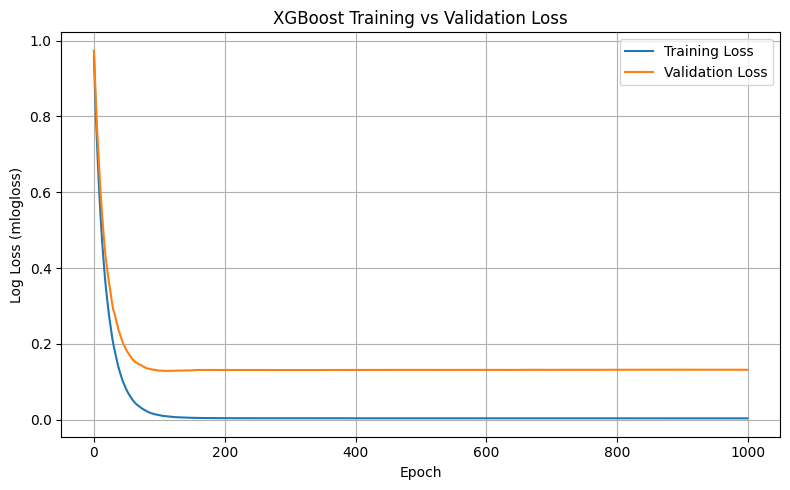


=== XGBoost (Validation set) performance ===
Accuracy: 0.9612582438451711
Balanced accuracy: 0.4707423015891268
Macro F1: 0.4776311831774167

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.88      0.91      5896
           M       0.00      0.00      0.00       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.49      0.47      0.48     28961
weighted avg       0.97      0.96      0.97     28961



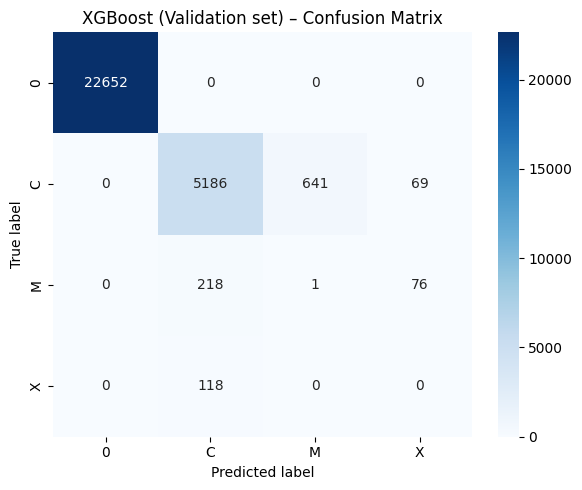


=== XGBoost (Test set) performance ===
Accuracy: 0.9334970111016225
Balanced accuracy: 0.6514891090019843
Macro F1: 0.5832617063198511

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.85      0.84      0.84      2001
           M       0.36      0.77      0.49       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.55      0.65      0.58      9368
weighted avg       0.93      0.93      0.93      9368



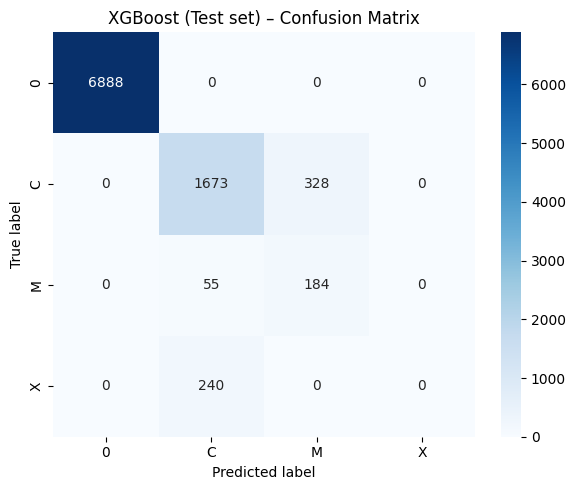

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
# Pipeline: impute -> scale -> XGBoost
xgb_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="multi:softmax",       
        num_class=len(class_names),         
        eval_metric="mlogloss",            
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=6,
        subsample=0.5,
        colsample_bytree=0.8,
        gamma=1,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("\n=== Training XGBoost model ===")

xgb_model.fit(X_train, y_train)


imputer = xgb_model.named_steps["imputer"]
scaler = xgb_model.named_steps["scaler"]

X_train_proc = scaler.transform(imputer.transform(X_train))
X_val_proc   = scaler.transform(imputer.transform(X_val))

xgb_for_plot = XGBClassifier(
    objective="multi:softmax",
    num_class=len(class_names),   
    eval_metric="mlogloss",
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=10,
    subsample=0.5,
    colsample_bytree=0.8,
    gamma=1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


xgb_for_plot.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=False
)


results = xgb_for_plot.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("XGBoost Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(
        classification_report(
            y_split,
            y_pred,
            labels=range(len(class_names)),   # force 0,1,2,3
            target_names=class_names,
            zero_division=0
        )
    )

  
    cm = confusion_matrix(
        y_split,
        y_pred,
        labels=range(len(class_names))
    )

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


eval_model("XGBoost (Validation set)", xgb_model, X_val, y_val)
eval_model("XGBoost (Test set)", xgb_model, X_test, y_test)


After tuning the hyperparameters:


=== Hyperparameter tuning with GridSearchCV (macro F1) ===
Fitting 3 folds for each of 192 candidates, totalling 576 fits

Best macro F1 (CV on train): 0.6503384907601686
Best params:
  clf__colsample_bytree: 0.8
  clf__gamma: 0.1
  clf__learning_rate: 0.2
  clf__max_depth: 4
  clf__n_estimators: 50
  clf__reg_lambda: 0.5
  clf__subsample: 1.0

Best macro F1 (CV on train): 0.6503384907601686
Best params:
  clf__colsample_bytree: 0.8
  clf__gamma: 0.1
  clf__learning_rate: 0.2
  clf__max_depth: 4
  clf__n_estimators: 50
  clf__reg_lambda: 0.5
  clf__subsample: 1.0


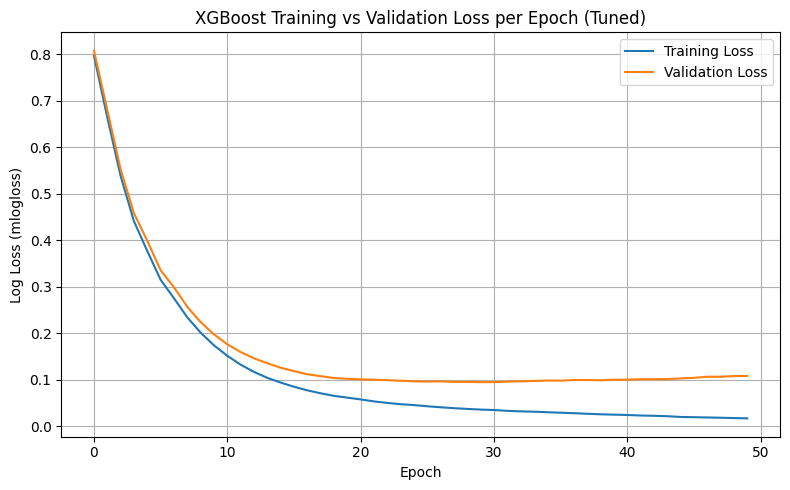


=== XGBoost (Validation set, tuned) performance ===
Accuracy: 0.9698214840647768
Balanced accuracy: 0.4820629613872088
Macro F1: 0.4831867078530322

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.93      0.92      0.93      5896
           M       0.00      0.01      0.01       295
           X       0.00      0.00      0.00       118

    accuracy                           0.97     28961
   macro avg       0.48      0.48      0.48     28961
weighted avg       0.97      0.97      0.97     28961



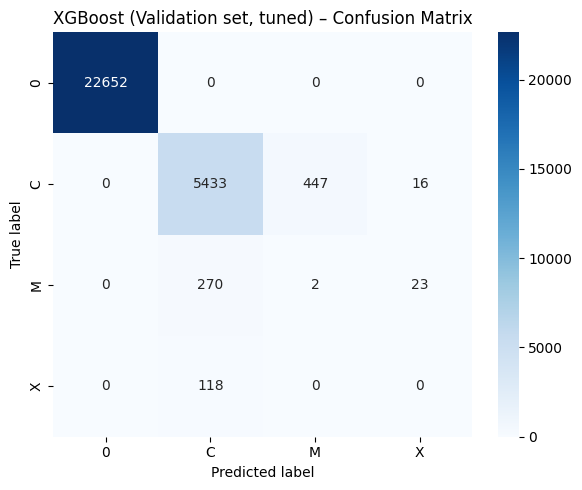


=== XGBoost (Test set, tuned) performance ===
Accuracy: 0.9310418445772843
Balanced accuracy: 0.6384835824765441
Macro F1: 0.5743259909059711

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.84      0.83      0.84      2001
           M       0.34      0.72      0.46       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.55      0.64      0.57      9368
weighted avg       0.92      0.93      0.93      9368



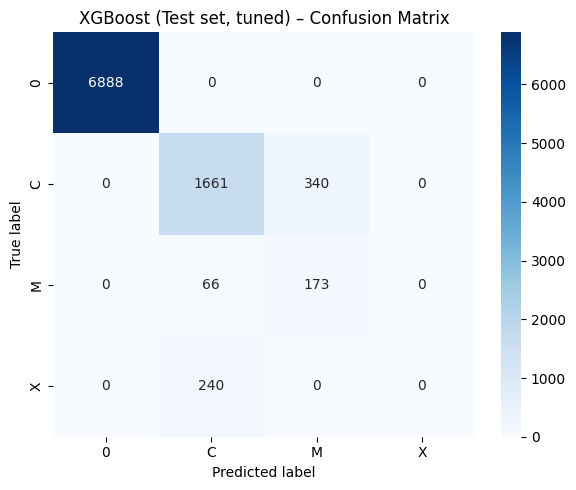

In [5]:
from xgboost import XGBClassifier
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE  
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns



xgb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=len(class_names),
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])


param_grid = {
    "clf__learning_rate":   [0.05, 0.1, 0.2],
    "clf__n_estimators":    [50, 100],
    "clf__max_depth":       [4, 6],
    "clf__subsample":       [0.8, 1.0],
    "clf__colsample_bytree":[0.8, 1.0],
    "clf__gamma":           [0.0, 0.1],
    "clf__reg_lambda":      [1.0, 0.5],
}

print("\n=== Hyperparameter tuning with GridSearchCV (macro F1) ===")
grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,                 
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("\nBest macro F1 (CV on train):", grid.best_score_)
print("Best params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_pipeline = grid.best_estimator_


best_imputer = best_pipeline.named_steps["imputer"]
best_scaler  = best_pipeline.named_steps["scaler"]
best_clf     = best_pipeline.named_steps["clf"]

X_train_proc = best_scaler.transform(best_imputer.transform(X_train))
X_val_proc   = best_scaler.transform(best_imputer.transform(X_val))


best_xgb_params = best_clf.get_params()

xgb_loss_model = XGBClassifier(
    **{
        # keep core params explicitly
        "objective": "multi:softmax",
        "num_class": len(class_names),
        "eval_metric": "mlogloss",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        # plus the tuned hyperparameters
        "learning_rate":   best_xgb_params["learning_rate"],
        "n_estimators":    best_xgb_params["n_estimators"],
        "max_depth":       best_xgb_params["max_depth"],
        "subsample":       best_xgb_params["subsample"],
        "colsample_bytree":best_xgb_params["colsample_bytree"],
        "gamma":           best_xgb_params["gamma"],
        "reg_lambda":      best_xgb_params["reg_lambda"],
    }
)

xgb_loss_model.fit(
    X_train_proc,
    y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=False
)


results = xgb_loss_model.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("XGBoost Training vs Validation Loss per Epoch (Tuned)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


eval_model("XGBoost (Validation set, tuned)", best_pipeline, X_val, y_val)
eval_model("XGBoost (Test set, tuned)",       best_pipeline, X_test, y_test)


We are using SMOTE, which is a strategy that increase the number of sample from classes that are not very present in the data by synthetically adding instances of these in the training dataset. 

Class dist BEFORE SMOTE: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Class distribution: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Full SMOTE sampling_strategy: {np.int64(0): 46602, np.int64(1): 46602, np.int64(2): 46602, np.int64(3): 46602}
Class dist AFTER SMOTE: Counter({np.int64(0): 46602, np.int64(1): 46602, np.int64(2): 46602, np.int64(3): 46602}) 

=== Hyperparameter tuning on validation set (macro F1) ===
Class dist AFTER SMOTE: Counter({np.int64(0): 46602, np.int64(1): 46602, np.int64(2): 46602, np.int64(3): 46602}) 

=== Hyperparameter tuning on validation set (macro F1) ===
New best macro F1=0.4772 with params: lr=0.05, n_estimators=50, max_depth=4, subsample=0.8, colsample_bytree=0.8, gamma=0.0
New best macro F1=0.4772 with params: lr=0.05, n_estimators=50, max_depth=4, subsample=0.8, colsample_bytree=0.8, gamma=0.0
New best macro F1=0.4886 with params: lr=0.05, n_estimators=50, max_depth=

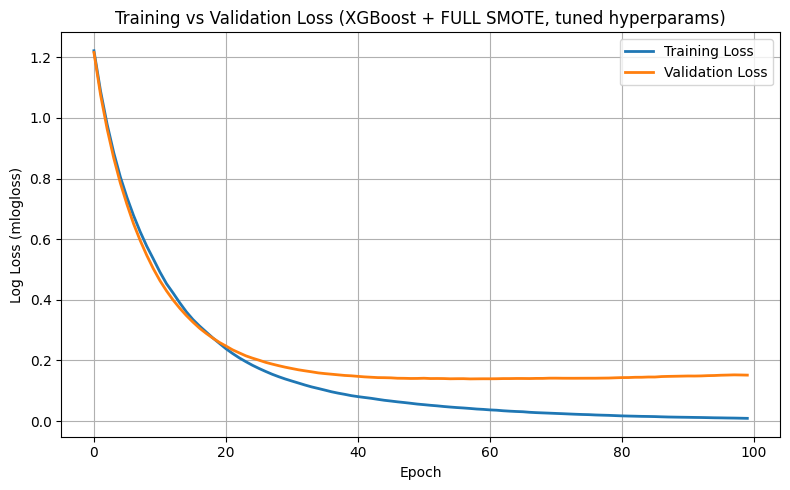


=== XGBoost + FULL SMOTE (Validation, tuned hyperparams) performance ===
Accuracy: 0.9612582438451711
Balanced accuracy: 0.5238759975162708
Macro F1: 0.5060747077536558

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.87      0.90      5896
           M       0.08      0.23      0.12       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.51      0.52      0.51     28961
weighted avg       0.97      0.96      0.97     28961



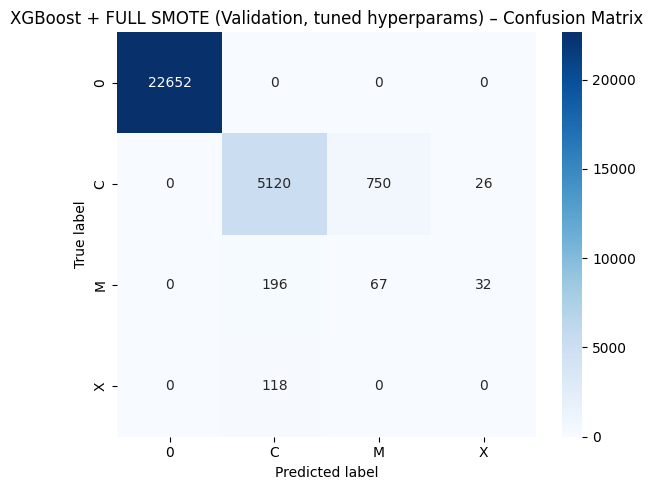


=== XGBoost + FULL SMOTE (Test, tuned hyperparams) performance ===
Accuracy: 0.9279461998292058
Balanced accuracy: 0.6735373552763367
Macro F1: 0.5837646330804098

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.86      0.79      0.82      2001
           M       0.34      0.89      0.49       239
           X       1.00      0.01      0.02       240

    accuracy                           0.93      9368
   macro avg       0.80      0.67      0.58      9368
weighted avg       0.95      0.93      0.92      9368



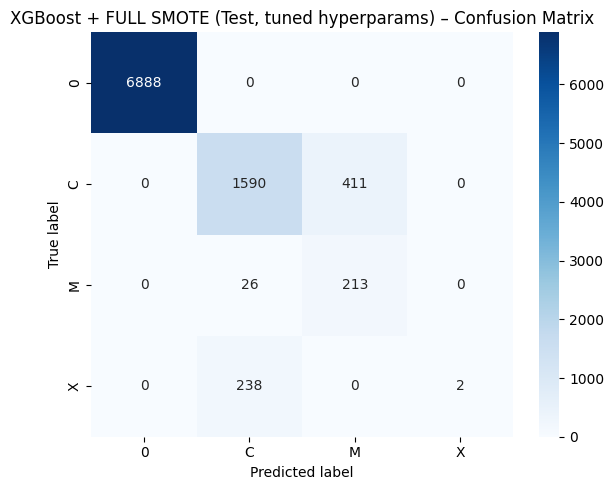

In [2]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42  

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


print("Class dist BEFORE SMOTE:", Counter(y_train))

class_dist = Counter(y_train)
print("Class distribution:", class_dist)

max_count = max(class_dist.values())
sampling_strategy = {cls: max_count for cls in class_dist.keys()}

print("Full SMOTE sampling_strategy:", sampling_strategy)

sm = SMOTE(
    random_state=RANDOM_STATE,
    sampling_strategy=sampling_strategy,
    k_neighbors=3
)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Class dist AFTER SMOTE:", Counter(y_train_res), "\n")


base_params = dict(
    objective="multi:softmax",
    num_class=len(class_names),
    eval_metric="mlogloss",
    reg_lambda=0.5,
    reg_alpha=0.1,
    min_child_weight=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    "n_estimators":  [50, 100],
    "max_depth":     [4, 6],
    "subsample":     [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma":         [0.0, 0.1]
}

best_score = -np.inf
best_params = None

print("=== Hyperparameter tuning on validation set (macro F1) ===")
for lr in param_grid["learning_rate"]:
    for n_est in param_grid["n_estimators"]:
        for md in param_grid["max_depth"]:
            for ss in param_grid["subsample"]:
                for cs in param_grid["colsample_bytree"]:
                    for gm in param_grid["gamma"]:
                        params = base_params.copy()
                        params.update(
                            learning_rate=lr,
                            n_estimators=n_est,
                            max_depth=md,
                            subsample=ss,
                            colsample_bytree=cs,
                            gamma=gm
                        )

                        model = XGBClassifier(**params)
                        model.fit(X_train_res, y_train_res)

                        # Evaluate on validation
                        y_val_pred = model.predict(X_val_scaled)
                        macro_f1 = f1_score(
                            y_val,
                            y_val_pred,
                            average="macro",
                            zero_division=0
                        )

                        if macro_f1 > best_score:
                            best_score = macro_f1
                            best_params = params.copy()

                            print(
                                f"New best macro F1={best_score:.4f} "
                                f"with params: lr={lr}, n_estimators={n_est}, "
                                f"max_depth={md}, subsample={ss}, "
                                f"colsample_bytree={cs}, gamma={gm}"
                            )

print("\nBest validation macro F1:", best_score)
print("Best params:", best_params)


xgb_best = XGBClassifier(**best_params)

xgb_best.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val_scaled, y_val)],
    verbose=False
)


results = xgb_best.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss (XGBoost + FULL SMOTE, tuned hyperparams)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()


eval_model("XGBoost + FULL SMOTE (Validation, tuned hyperparams)", xgb_best, X_val_scaled, y_val)
eval_model("XGBoost + FULL SMOTE (Test, tuned hyperparams)",       xgb_best, X_test_scaled, y_test)


Having seen that SMOTE did not yield any good results, we thought about why that might be, and we came to the conclusion that since we are oversampling all the different classes, that does not give X and M any advantage to become better represented. 
For this reason, our next step is to oversample X.

Initial class distribution:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

After ensuring X in TRAIN and TEST:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

Class dist BEFORE SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Class distribution (TRAIN): Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Sampling strategy for SMOTE (X only): {3: 1200}
Class dist AFTER SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, 

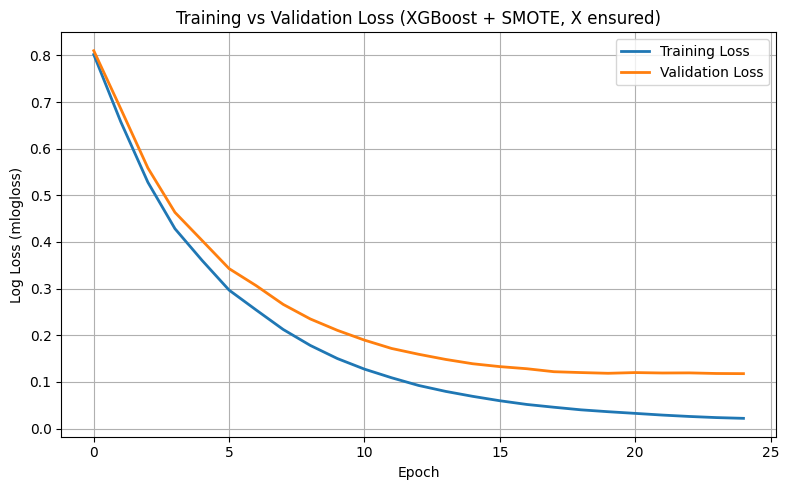


=== XGBoost + SMOTE (Validation) performance ===
Accuracy: 0.9616380649839439
Balanced accuracy: 0.4720137754984707
Macro F1: 0.4780756074436931

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.88      0.91      5896
           M       0.00      0.01      0.00       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.48      0.47      0.48     28961
weighted avg       0.97      0.96      0.97     28961



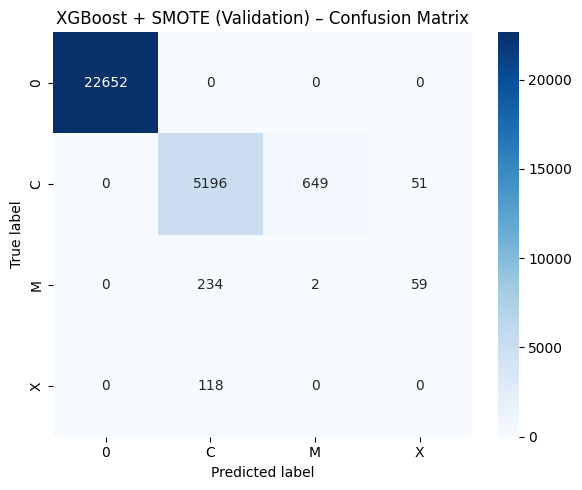


=== XGBoost + SMOTE (Test) performance ===
Accuracy: 0.9275192143467123
Balanced accuracy: 0.6371239066659139
Macro F1: 0.5680472025738785

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.84      0.81      0.83      2001
           M       0.32      0.74      0.45       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.54      0.64      0.57      9368
weighted avg       0.92      0.93      0.92      9368



c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

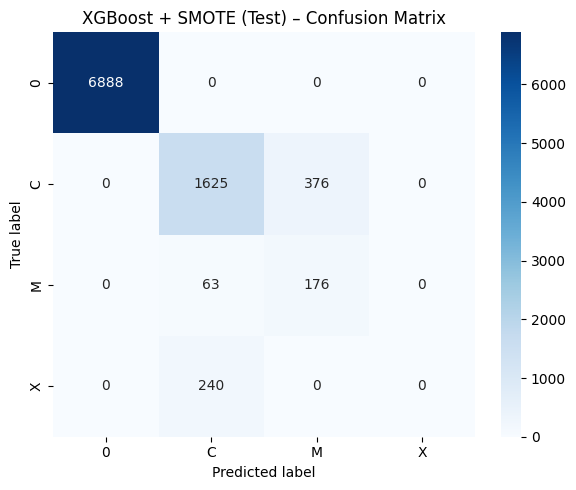

In [7]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns




label_X = class_names.index("X")  


X_train = np.asarray(X_train)
X_val   = np.asarray(X_val)
X_test  = np.asarray(X_test)

y_train = np.asarray(y_train)
y_val   = np.asarray(y_val)
y_test  = np.asarray(y_test)

print("Initial class distribution:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


if label_X not in np.unique(y_train):
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) == 0:
        print(f"[WARNING] No X samples in VAL to move into TRAIN.")
    else:
        n_move_train = max(1, len(idx_x_val) // 3)
        move_idx_train = idx_x_val[:n_move_train]

        print(f"Moving {n_move_train} X samples from VAL to TRAIN.")

        X_train = np.concatenate([X_train, X_val[move_idx_train]], axis=0)
        y_train = np.concatenate([y_train, y_val[move_idx_train]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_train] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]


if label_X not in np.unique(y_test):
 
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) > 0:
        n_move_test = max(1, len(idx_x_val) // 3)
        move_idx_test = idx_x_val[:n_move_test]

        print(f"Moving {n_move_test} X samples from VAL to TEST.")

        
        X_test = np.concatenate([X_test, X_val[move_idx_test]], axis=0)
        y_test = np.concatenate([y_test, y_val[move_idx_test]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_test] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]
    else:
        
        idx_x_train = np.where(y_train == label_X)[0]
        if len(idx_x_train) > 1:
            n_move_test = 1  
            move_idx_test = idx_x_train[:n_move_test]

            print(f"Moving {n_move_test} X sample from TRAIN to TEST.")

          
            X_test = np.concatenate([X_test, X_train[move_idx_test]], axis=0)
            y_test = np.concatenate([y_test, y_train[move_idx_test]], axis=0)

         
            mask_train = np.ones(len(y_train), dtype=bool)
            mask_train[move_idx_test] = False
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
        else:
            print(f"[WARNING] Could not ensure X in TEST (too few X samples globally).")

print("\nAfter ensuring X in TRAIN and TEST:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


print("\nClass dist BEFORE SMOTE on TRAIN:", Counter(y_train))

class_dist = Counter(y_train)
print("Class distribution (TRAIN):", class_dist)

sampling_strategy = None
k_neighbors = 3

if label_X in class_dist and class_dist[label_X] > k_neighbors:
    x_count = class_dist[label_X]
    # Oversample X, e.g. 5x (you can tune this factor)
    target_x = x_count * 5    
    sampling_strategy = {label_X: target_x}
    print("Sampling strategy for SMOTE (X only):", sampling_strategy)

    sm = SMOTE(
        random_state=RANDOM_STATE,
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors
    )
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    print("Class dist AFTER SMOTE on TRAIN:", Counter(y_train_res), "\n")
else:
    print(f"[WARNING] Too few X samples in TRAIN for SMOTE (need > {k_neighbors}).")
    X_train_res, y_train_res = X_train_scaled, y_train


xgb_smote = XGBClassifier(
    objective="multi:softmax",       # Multi-class classification
    num_class=len(class_names),      # Number of classes in your dataset
    eval_metric="mlogloss",          # Log-loss metric for multi-class classification
    learning_rate=0.2,               # Learning rate
    n_estimators=25,                # Number of boosting rounds
    max_depth=6,                     # Depth of each tree, controls model complexity
    subsample=0.8,                   # Randomly sample a portion of the training set for each tree
    colsample_bytree=0.8,            # Randomly sample features for each tree
    gamma=0.1,                       # Minimum loss reduction required to make a further partition
    reg_lambda=0.5,                  # L2 regularization to prevent overfitting
    reg_alpha=0.1,                   # L1 regularization to encourage sparsity
    min_child_weight=1,              # Minimum sum of instance weight (hessian) in a child
    random_state=RANDOM_STATE,       # Ensure reproducibility
    n_jobs=-1                        # Use all CPU threads for training
)


xgb_smote.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val_scaled, y_val)],
    verbose=False
)


results = xgb_smote.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss (XGBoost + SMOTE, X ensured)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label"); plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix"); plt.tight_layout(); plt.show()

eval_model("XGBoost + SMOTE (Validation)", xgb_smote, X_val_scaled, y_val)
eval_model("XGBoost + SMOTE (Test)",       xgb_smote, X_test_scaled, y_test)


In this case, we are using class weights to penalize the loss on minority classes.

Initial class distribution:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

After ensuring X in TRAIN and TEST:
TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
VAL  : Counter({np.int64(0): 22652, np.int64(1): 5896, np.int64(2): 295, np.int64(3): 118})
TEST : Counter({np.int64(0): 6888, np.int64(1): 2001, np.int64(3): 240, np.int64(2): 239})

Class dist BEFORE SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Class distribution (TRAIN): Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, np.int64(3): 240})
Sampling strategy for SMOTE (X only): {3: 1200}
Class dist AFTER SMOTE on TRAIN: Counter({np.int64(0): 46602, np.int64(1): 9080, np.int64(2): 2044, 

c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:46:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


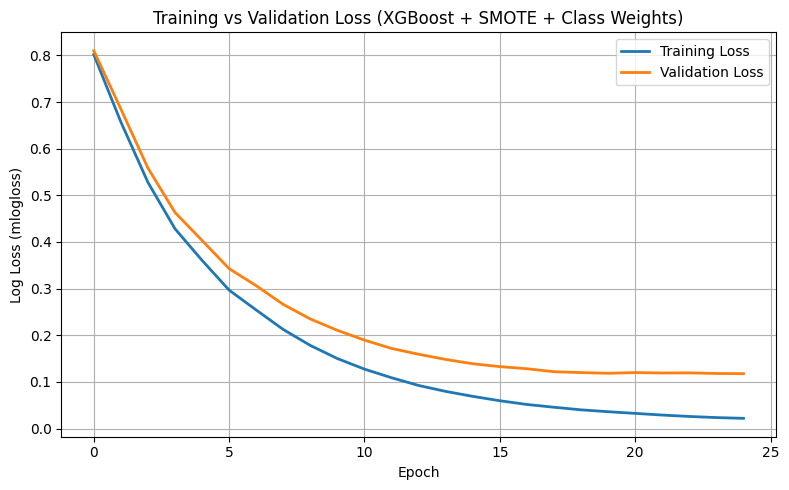


=== XGBoost + SMOTE (Validation) performance ===
Accuracy: 0.9616380649839439
Balanced accuracy: 0.4720137754984707
Macro F1: 0.4780756074436931

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22652
           C       0.94      0.88      0.91      5896
           M       0.00      0.01      0.00       295
           X       0.00      0.00      0.00       118

    accuracy                           0.96     28961
   macro avg       0.48      0.47      0.48     28961
weighted avg       0.97      0.96      0.97     28961



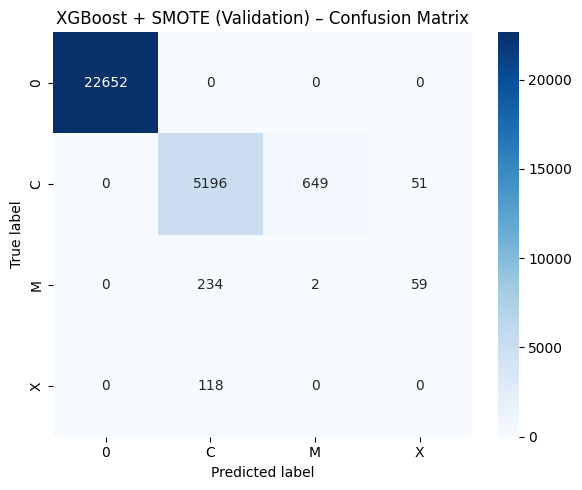


=== XGBoost + SMOTE (Test) performance ===
Accuracy: 0.9275192143467123
Balanced accuracy: 0.6371239066659139
Macro F1: 0.5680472025738785

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6888
           C       0.84      0.81      0.83      2001
           M       0.32      0.74      0.45       239
           X       0.00      0.00      0.00       240

    accuracy                           0.93      9368
   macro avg       0.54      0.64      0.57      9368
weighted avg       0.92      0.93      0.92      9368



c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

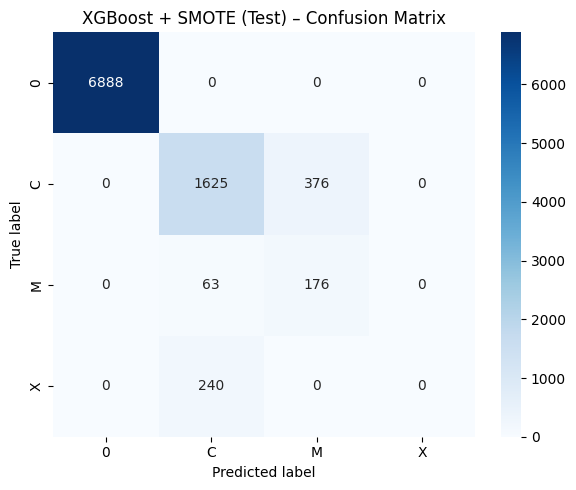

In [8]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns




label_X = class_names.index("X")  


X_train = np.asarray(X_train)
X_val   = np.asarray(X_val)
X_test  = np.asarray(X_test)

y_train = np.asarray(y_train)
y_val   = np.asarray(y_val)
y_test  = np.asarray(y_test)

print("Initial class distribution:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


if label_X not in np.unique(y_train):
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) == 0:
        print(f"[WARNING] No X samples in VAL to move into TRAIN.")
    else:
        n_move_train = max(1, len(idx_x_val) // 3)
        move_idx_train = idx_x_val[:n_move_train]

        print(f"Moving {n_move_train} X samples from VAL to TRAIN.")

        X_train = np.concatenate([X_train, X_val[move_idx_train]], axis=0)
        y_train = np.concatenate([y_train, y_val[move_idx_train]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_train] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]


if label_X not in np.unique(y_test):
 
    idx_x_val = np.where(y_val == label_X)[0]
    if len(idx_x_val) > 0:
        n_move_test = max(1, len(idx_x_val) // 3)
        move_idx_test = idx_x_val[:n_move_test]

        print(f"Moving {n_move_test} X samples from VAL to TEST.")

        
        X_test = np.concatenate([X_test, X_val[move_idx_test]], axis=0)
        y_test = np.concatenate([y_test, y_val[move_idx_test]], axis=0)

        
        mask_val = np.ones(len(y_val), dtype=bool)
        mask_val[move_idx_test] = False
        X_val = X_val[mask_val]
        y_val = y_val[mask_val]
    else:
        
        idx_x_train = np.where(y_train == label_X)[0]
        if len(idx_x_train) > 1:
            n_move_test = 1  
            move_idx_test = idx_x_train[:n_move_test]

            print(f"Moving {n_move_test} X sample from TRAIN to TEST.")

          
            X_test = np.concatenate([X_test, X_train[move_idx_test]], axis=0)
            y_test = np.concatenate([y_test, y_train[move_idx_test]], axis=0)

         
            mask_train = np.ones(len(y_train), dtype=bool)
            mask_train[move_idx_test] = False
            X_train = X_train[mask_train]
            y_train = y_train[mask_train]
        else:
            print(f"[WARNING] Could not ensure X in TEST (too few X samples globally).")

print("\nAfter ensuring X in TRAIN and TEST:")
print("TRAIN:", Counter(y_train))
print("VAL  :", Counter(y_val))
print("TEST :", Counter(y_test))


imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


print("\nClass dist BEFORE SMOTE on TRAIN:", Counter(y_train))

class_dist = Counter(y_train)
print("Class distribution (TRAIN):", class_dist)

sampling_strategy = None
k_neighbors = 3

if label_X in class_dist and class_dist[label_X] > k_neighbors:
    x_count = class_dist[label_X]
    # Oversample X, e.g. 5x (you can tune this factor)
    target_x = x_count * 5    
    sampling_strategy = {label_X: target_x}
    print("Sampling strategy for SMOTE (X only):", sampling_strategy)

    sm = SMOTE(
        random_state=RANDOM_STATE,
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors
    )
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
    print("Class dist AFTER SMOTE on TRAIN:", Counter(y_train_res), "\n")
else:
    print(f"[WARNING] Too few X samples in TRAIN for SMOTE (need > {k_neighbors}).")
    X_train_res, y_train_res = X_train_scaled, y_train
    


weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_res),
    y=y_train_res
)

class_weights = {i: w for i, w in enumerate(weights)}
print(class_weights)


xgb_smote = XGBClassifier(
    objective="multi:softmax",       # Multi-class classification
    num_class=len(class_names),      # Number of classes in your dataset
    eval_metric="mlogloss",          # Log-loss metric for multi-class classification
    learning_rate=0.2,               # Learning rate
    n_estimators=25,                # Number of boosting rounds
    max_depth=6,                     # Depth of each tree, controls model complexity
    subsample=0.8,                   # Randomly sample a portion of the training set for each tree
    colsample_bytree=0.8,            # Randomly sample features for each tree
    gamma=0.1,                       # Minimum loss reduction required to make a further partition
    reg_lambda=0.5,                  # L2 regularization to prevent overfitting
    reg_alpha=0.1,                   # L1 regularization to encourage sparsity
    min_child_weight=1,              # Minimum sum of instance weight (hessian) in a child
    random_state=RANDOM_STATE,       # Ensure reproducibility
    n_jobs=-1, 
    class_weight = class_weights# Use all CPU threads for training
)


xgb_smote.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_val_scaled, y_val)],
    verbose=False
)


results = xgb_smote.evals_result()

train_loss = results["validation_0"]["mlogloss"]
val_loss   = results["validation_1"]["mlogloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss (XGBoost + SMOTE + Class Weights)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def eval_model(name, model, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    bal_acc = balanced_accuracy_score(y_split, y_pred)
    macro_f1 = f1_score(y_split, y_pred, average="macro", zero_division=0)

    print(f"\n=== {name} performance ===")
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:")
    print(classification_report(y_split, y_pred, target_names=class_names))

    cm = confusion_matrix(y_split, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted label"); plt.ylabel("True label")
    plt.title(f"{name} – Confusion Matrix"); plt.tight_layout(); plt.show()

# ---------------------------------------------------------
# 5) Evaluate (no SMOTE on val/test)
# ---------------------------------------------------------
eval_model("XGBoost + SMOTE (Validation)", xgb_smote, X_val_scaled, y_val)
eval_model("XGBoost + SMOTE (Test)",       xgb_smote, X_test_scaled, y_test)


RE-EVALUATING ALL MODELS FOR COMPARISON

[1/4] XGBoost (Basic)


c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\Assignmetn\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SimpleImputer was fitted w

  Val - Balanced Acc: 0.4707, Precision: 0.4852, Recall: 0.4707, Macro F1: 0.4776
  Test - Balanced Acc: 0.6515, Precision: 0.5524, Recall: 0.6515, Macro F1: 0.5833

[2/4] XGBoost (Tuned)
  Val - Balanced Acc: 0.4821, Precision: 0.4844, Recall: 0.4821, Macro F1: 0.4832
  Test - Balanced Acc: 0.6385, Precision: 0.5454, Recall: 0.6385, Macro F1: 0.5743

[3/4] XGBoost + Full SMOTE
  Val - Balanced Acc: 0.5239, Precision: 0.5061, Recall: 0.5239, Macro F1: 0.5061
  Test - Balanced Acc: 0.6735, Precision: 0.7997, Recall: 0.6735, Macro F1: 0.5838

[4/4] XGBoost + SMOTE (X) + Class Weights
  Val - Balanced Acc: 0.4720, Precision: 0.4849, Recall: 0.4720, Macro F1: 0.4781
  Test - Balanced Acc: 0.6371, Precision: 0.5404, Recall: 0.6371, Macro F1: 0.5680

VALIDATION SET METRICS
                               balanced_accuracy  precision    recall  \
XGBoost (Basic)                         0.470742   0.485178  0.470742   
XGBoost (Tuned)                         0.482063   0.484450  0.482063   
XGB

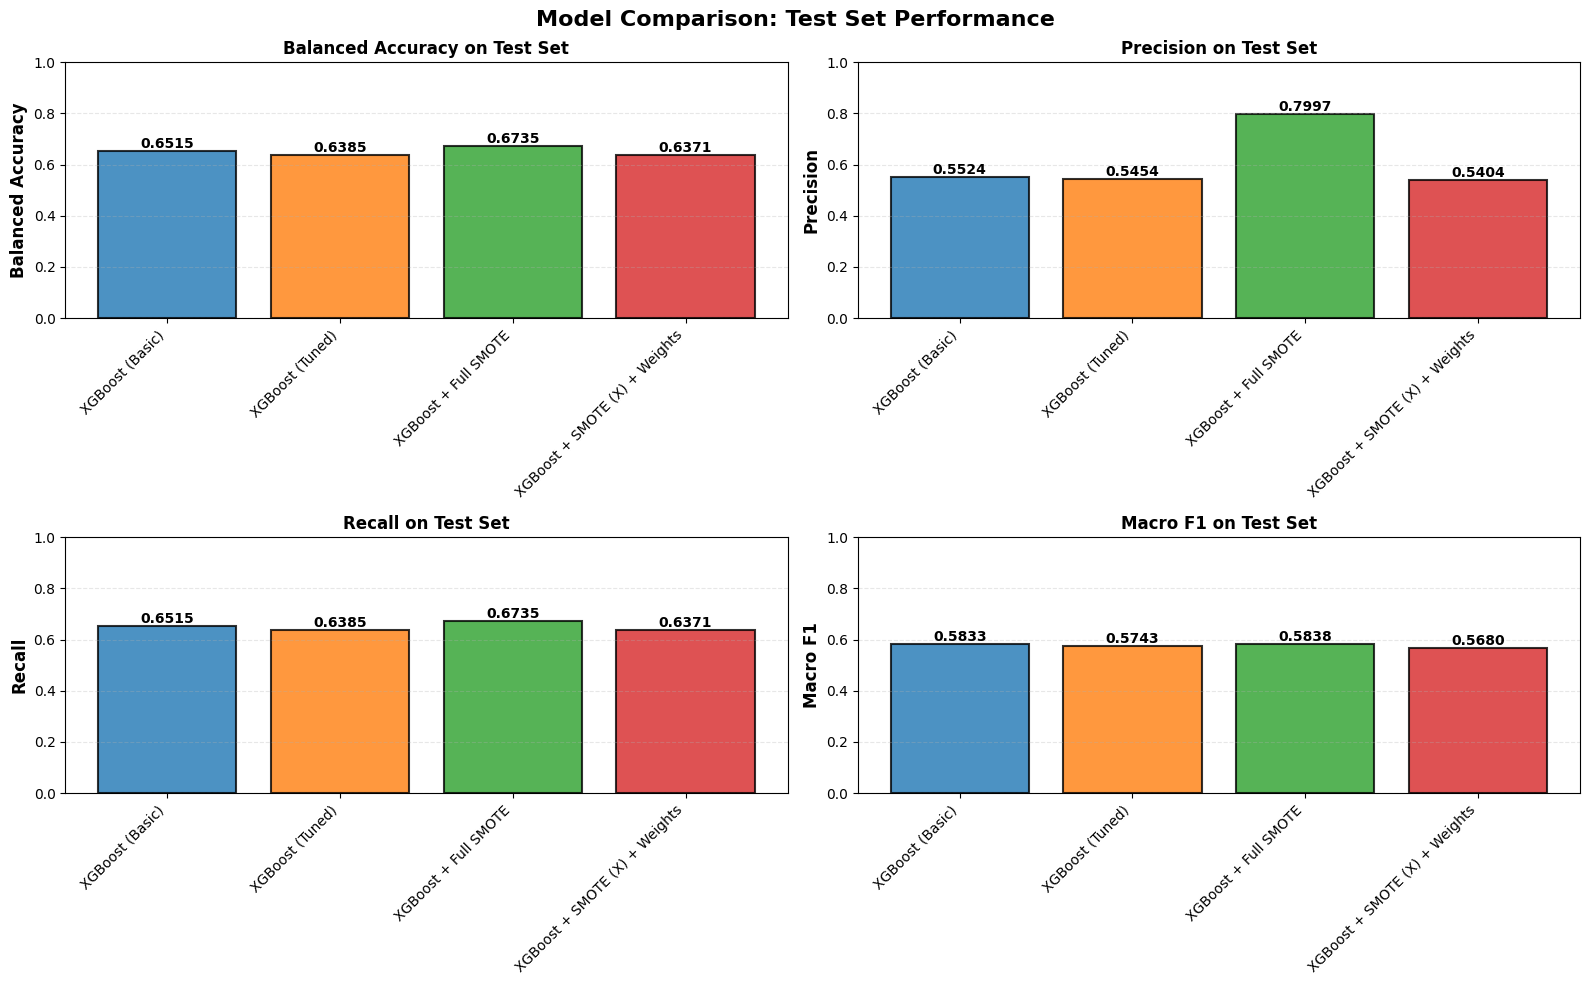

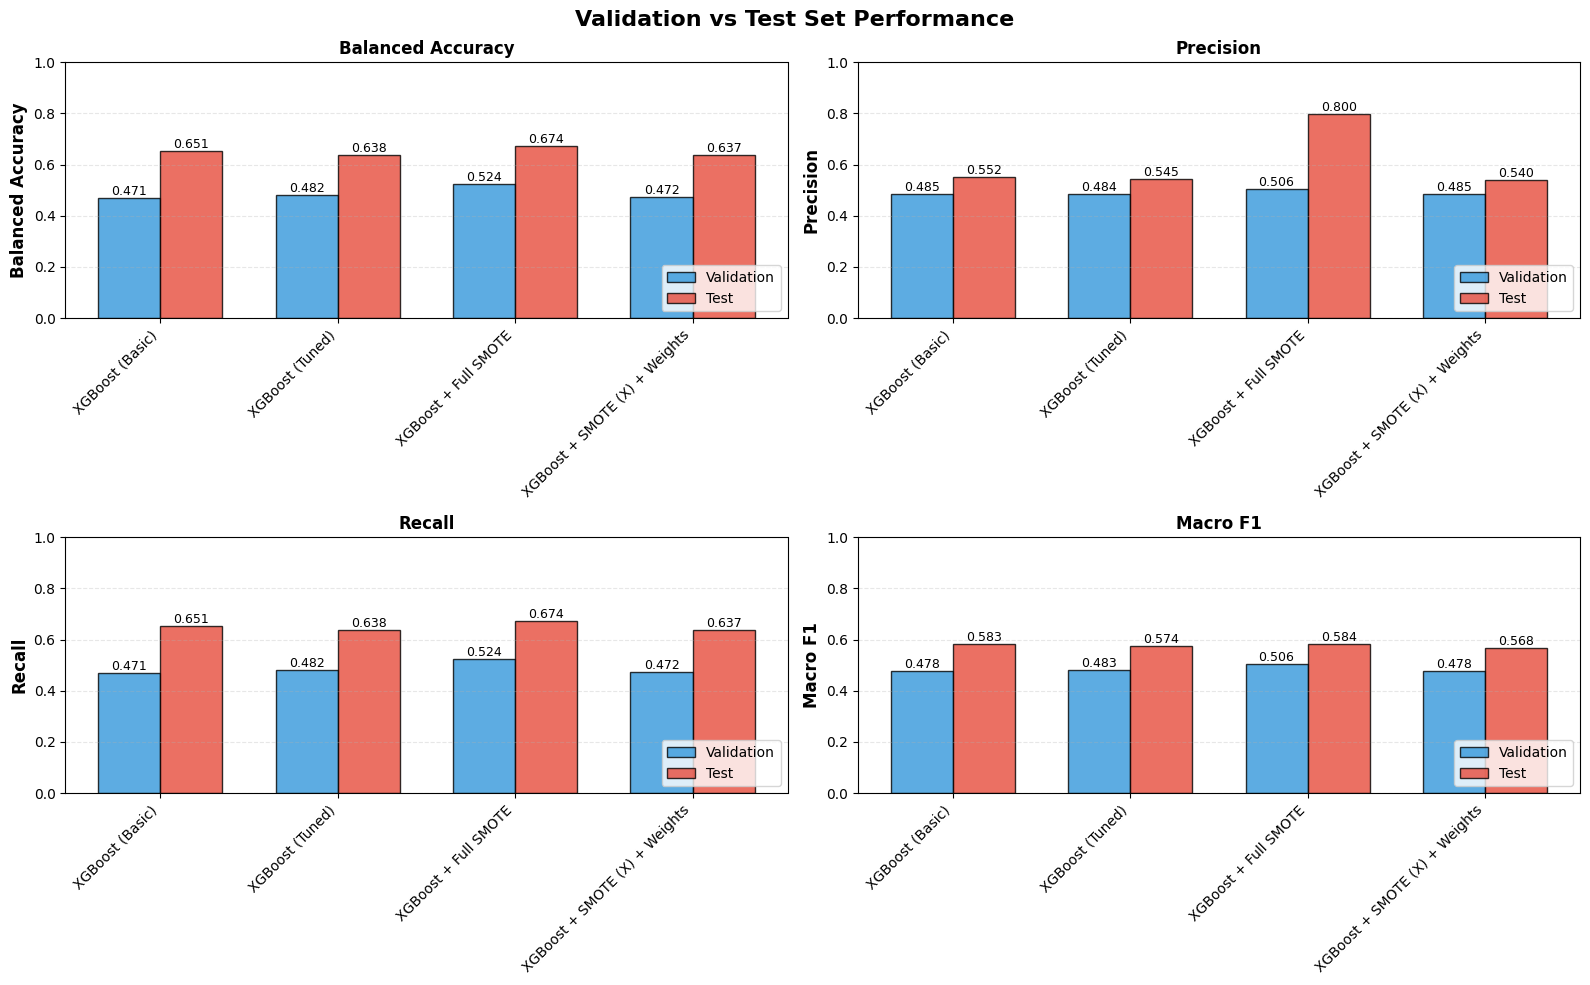

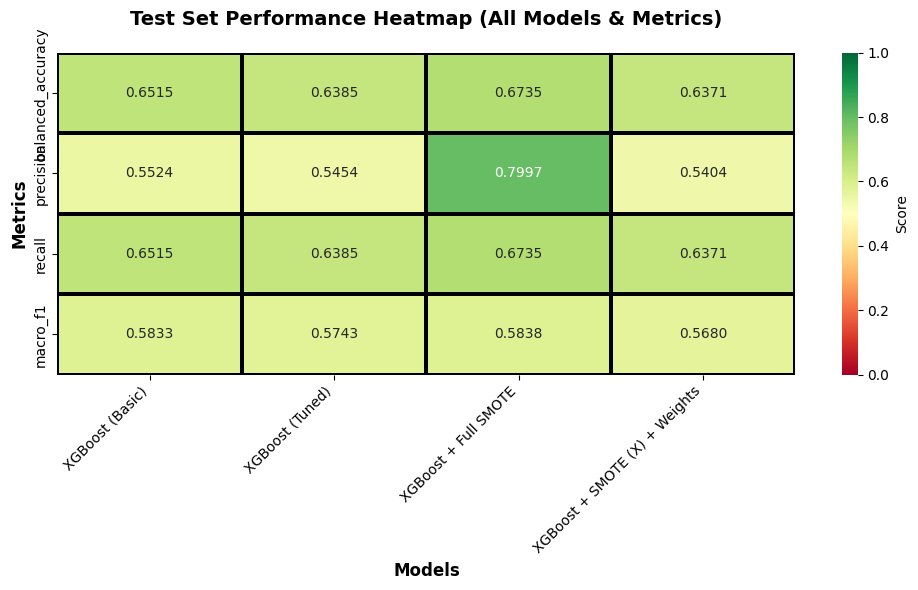

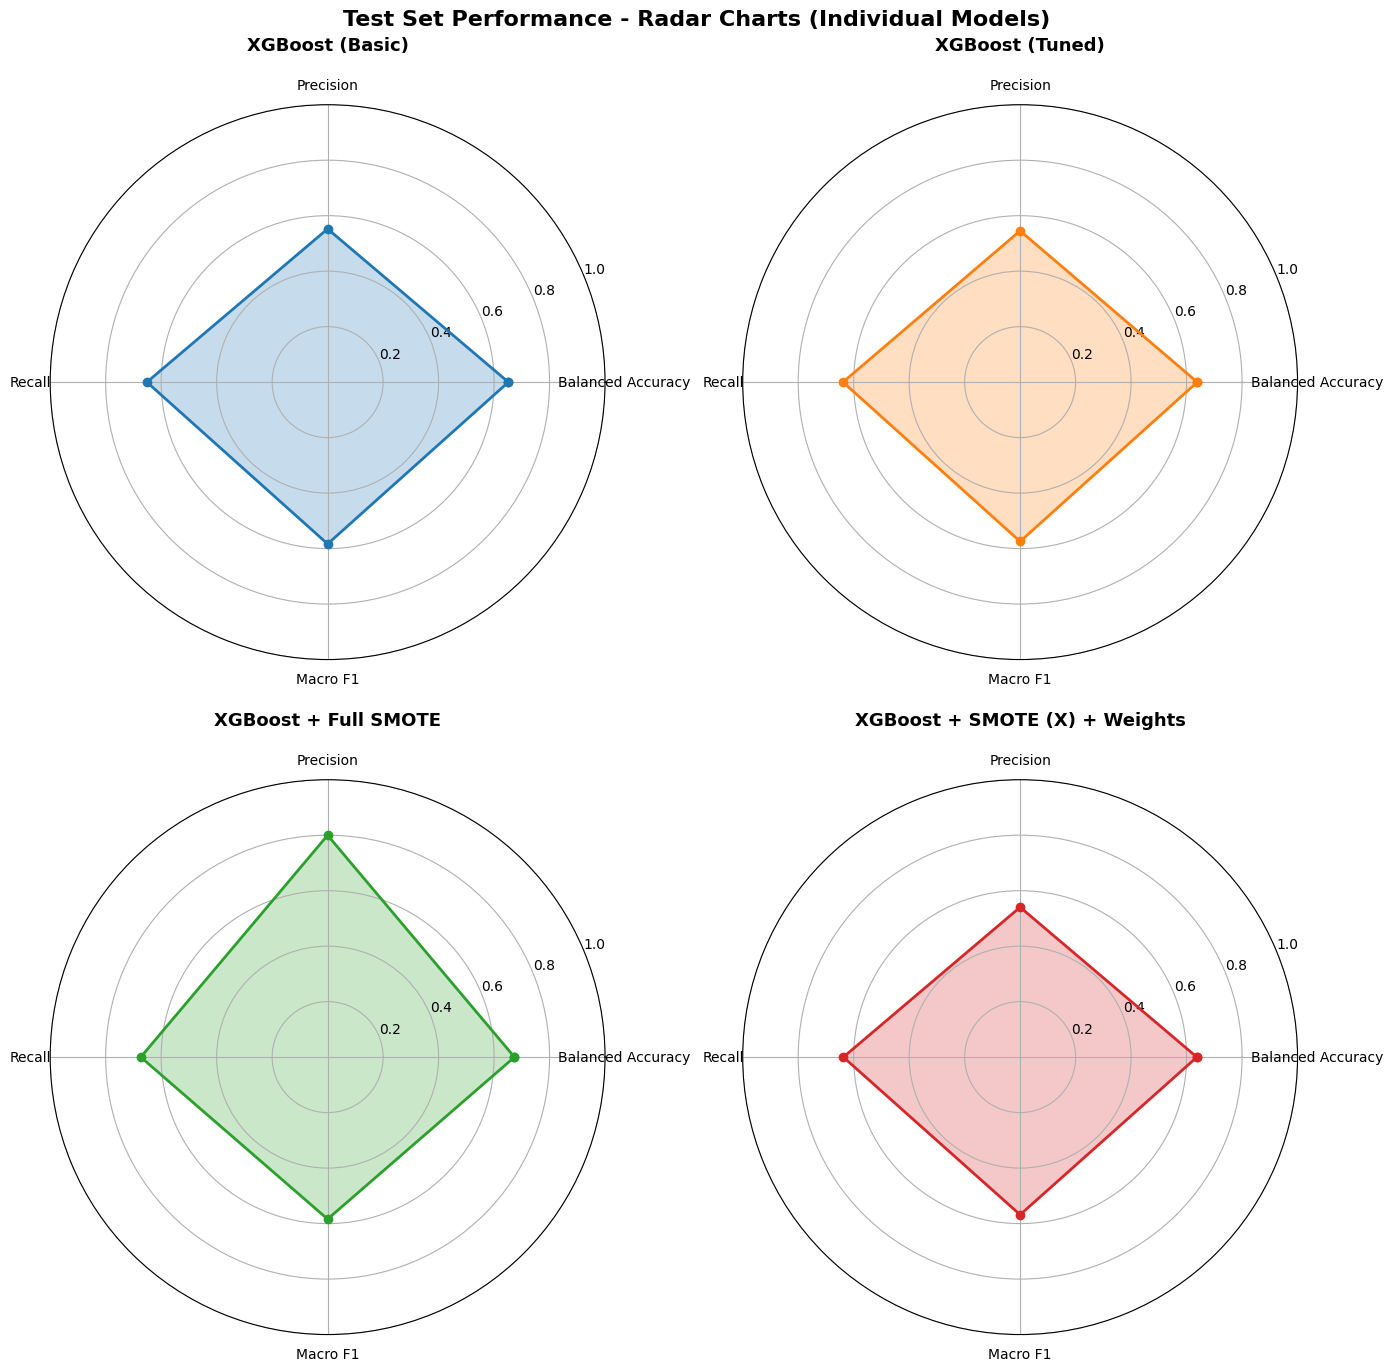

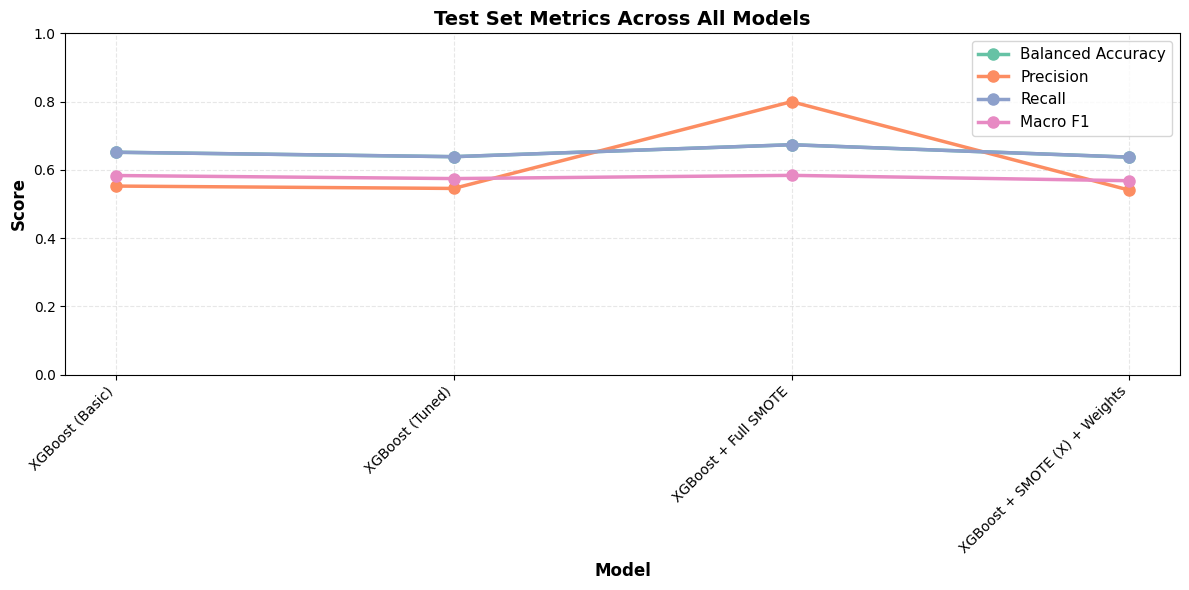


SUMMARY: BEST PERFORMING MODEL BY METRIC (TEST SET)
Balanced Accuracy   : XGBoost + Full SMOTE                     (Score: 0.6735)
Precision           : XGBoost + Full SMOTE                     (Score: 0.7997)
Recall              : XGBoost + Full SMOTE                     (Score: 0.6735)
Macro F1            : XGBoost + Full SMOTE                     (Score: 0.5838)

OVERALL BEST MODEL (Highest average score across all metrics)
Model: XGBoost + Full SMOTE
Average Test Score: 0.6826

Breakdown:
  Balanced Accuracy: 0.6735
  Precision: 0.7997
  Recall: 0.6735
  Macro F1: 0.5838


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

model_results = {
    "XGBoost (Basic)": {
        "val": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0},
        "test": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0}
    },
    "XGBoost (Tuned)": {
        "val": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0},
        "test": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0}
    },
    "XGBoost + Full SMOTE": {
        "val": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0},
        "test": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0}
    },
    "XGBoost + SMOTE (X) + Weights": {
        "val": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0},
        "test": {"balanced_accuracy": 0, "precision": 0, "recall": 0, "macro_f1": 0}
    }
}

# Helper function to calculate metrics
def get_metrics(y_true, y_pred):
    """Calculate balanced accuracy, precision, recall, and macro F1 score."""
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    macro_f1_score = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return {"balanced_accuracy": bal_acc, "precision": precision, "recall": recall, "macro_f1": macro_f1_score}




print("=" * 80)
print("RE-EVALUATING ALL MODELS FOR COMPARISON")
print("=" * 80)

print("\n[1/4] XGBoost (Basic)")
y_val_pred_basic = xgb_model.predict(X_val)
y_test_pred_basic = xgb_model.predict(X_test)
model_results["XGBoost (Basic)"]["val"] = get_metrics(y_val, y_val_pred_basic)
model_results["XGBoost (Basic)"]["test"] = get_metrics(y_test, y_test_pred_basic)
print(f"  Val - Balanced Acc: {model_results['XGBoost (Basic)']['val']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost (Basic)']['val']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost (Basic)']['val']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost (Basic)']['val']['macro_f1']:.4f}")
print(f"  Test - Balanced Acc: {model_results['XGBoost (Basic)']['test']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost (Basic)']['test']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost (Basic)']['test']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost (Basic)']['test']['macro_f1']:.4f}")

print("\n[2/4] XGBoost (Tuned)")
y_val_pred_tuned = best_pipeline.predict(X_val)
y_test_pred_tuned = best_pipeline.predict(X_test)
model_results["XGBoost (Tuned)"]["val"] = get_metrics(y_val, y_val_pred_tuned)
model_results["XGBoost (Tuned)"]["test"] = get_metrics(y_test, y_test_pred_tuned)
print(f"  Val - Balanced Acc: {model_results['XGBoost (Tuned)']['val']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost (Tuned)']['val']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost (Tuned)']['val']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost (Tuned)']['val']['macro_f1']:.4f}")
print(f"  Test - Balanced Acc: {model_results['XGBoost (Tuned)']['test']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost (Tuned)']['test']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost (Tuned)']['test']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost (Tuned)']['test']['macro_f1']:.4f}")

# 3. XGBoost + Full SMOTE - using xgb_best from cell 5
print("\n[3/4] XGBoost + Full SMOTE")
y_val_pred_fullsmote = xgb_best.predict(X_val_scaled)
y_test_pred_fullsmote = xgb_best.predict(X_test_scaled)
model_results["XGBoost + Full SMOTE"]["val"] = get_metrics(y_val, y_val_pred_fullsmote)
model_results["XGBoost + Full SMOTE"]["test"] = get_metrics(y_test, y_test_pred_fullsmote)
print(f"  Val - Balanced Acc: {model_results['XGBoost + Full SMOTE']['val']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost + Full SMOTE']['val']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost + Full SMOTE']['val']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost + Full SMOTE']['val']['macro_f1']:.4f}")
print(f"  Test - Balanced Acc: {model_results['XGBoost + Full SMOTE']['test']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost + Full SMOTE']['test']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost + Full SMOTE']['test']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost + Full SMOTE']['test']['macro_f1']:.4f}")

# 4. XGBoost + SMOTE (X) + Class Weights - using xgb_smote from cell 6
print("\n[4/4] XGBoost + SMOTE (X) + Class Weights")
y_val_pred_smotex = xgb_smote.predict(X_val_scaled)
y_test_pred_smotex = xgb_smote.predict(X_test_scaled)
model_results["XGBoost + SMOTE (X) + Weights"]["val"] = get_metrics(y_val, y_val_pred_smotex)
model_results["XGBoost + SMOTE (X) + Weights"]["test"] = get_metrics(y_test, y_test_pred_smotex)
print(f"  Val - Balanced Acc: {model_results['XGBoost + SMOTE (X) + Weights']['val']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost + SMOTE (X) + Weights']['val']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost + SMOTE (X) + Weights']['val']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost + SMOTE (X) + Weights']['val']['macro_f1']:.4f}")
print(f"  Test - Balanced Acc: {model_results['XGBoost + SMOTE (X) + Weights']['test']['balanced_accuracy']:.4f}, "
      f"Precision: {model_results['XGBoost + SMOTE (X) + Weights']['test']['precision']:.4f}, "
      f"Recall: {model_results['XGBoost + SMOTE (X) + Weights']['test']['recall']:.4f}, "
      f"Macro F1: {model_results['XGBoost + SMOTE (X) + Weights']['test']['macro_f1']:.4f}")

# ============================================================================
# Create comparison visualizations
# ============================================================================

# Prepare data for plotting
models = list(model_results.keys())
metrics = ["balanced_accuracy", "precision", "recall", "macro_f1"]
metric_names = ["Balanced Accuracy", "Precision", "Recall", "Macro F1"]

# Create dataframes for val and test
val_data = pd.DataFrame({
    metric: [model_results[m]["val"][metric] for m in models]
    for metric in metrics
}, index=models)

test_data = pd.DataFrame({
    metric: [model_results[m]["test"][metric] for m in models]
    for metric in metrics
}, index=models)

print("\n" + "=" * 80)
print("VALIDATION SET METRICS")
print("=" * 80)
print(val_data)

print("\n" + "=" * 80)
print("TEST SET METRICS")
print("=" * 80)
print(test_data)


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
fig.suptitle("Model Comparison: Test Set Performance", fontsize=16, fontweight="bold")

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    test_values = [model_results[m]["test"][metric] for m in models]
    bars = ax.bar(range(len(models)), test_values, color=colors, alpha=0.8, edgecolor="black", linewidth=1.5)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, test_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_ylabel(metric_names[idx], fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_title(f"{metric_names[idx]} on Test Set", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
fig.suptitle("Validation vs Test Set Performance", fontsize=16, fontweight="bold")

x = np.arange(len(models))
width = 0.35

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    val_values = [model_results[m]["val"][metric] for m in models]
    test_values = [model_results[m]["test"][metric] for m in models]
    
    bars1 = ax.bar(x - width/2, val_values, width, label="Validation", alpha=0.8, color="#3498db", edgecolor="black")
    bars2 = ax.bar(x + width/2, test_values, width, label="Test", alpha=0.8, color="#e74c3c", edgecolor="black")
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel(metric_names[idx], fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_title(f"{metric_names[idx]}", fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

heatmap_data = test_data.T  

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.4f',
    cmap='RdYlGn',
    cbar_kws={'label': 'Score'},
    linewidths=1.5,
    linecolor='black',
    vmin=0,
    vmax=1.0,
    ax=ax,
    cbar=True
)

ax.set_title("Test Set Performance Heatmap (All Models & Metrics)", fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Metrics", fontsize=12, fontweight='bold')
ax.set_xlabel("Models", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


from math import pi

fig, axes = plt.subplots(2, 2, figsize=(14, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]  # Complete the circle

for idx, model_name in enumerate(models):
    ax = axes[idx]
    
    values = [model_results[model_name]["test"][metric] for metric in metrics]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label='Test', color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names, size=10)
    ax.set_ylim(0, 1)
    ax.set_title(model_name, size=13, fontweight='bold', pad=20)
    ax.grid(True)

plt.suptitle("Test Set Performance - Radar Charts (Individual Models)", 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(models))

for idx, metric in enumerate(metrics):
    test_values = [model_results[m]["test"][metric] for m in models]
    ax.plot(x_pos, test_values, marker='o', linewidth=2.5, markersize=8, 
            label=metric_names[idx], color=plt.cm.Set2(idx))

ax.set_xlabel("Model", fontsize=12, fontweight='bold')
ax.set_ylabel("Score", fontsize=12, fontweight='bold')
ax.set_title("Test Set Metrics Across All Models", fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


print("\n" + "=" * 80)
print("SUMMARY: BEST PERFORMING MODEL BY METRIC (TEST SET)")
print("=" * 80)

for metric, name in zip(metrics, metric_names):
    best_model = max(models, key=lambda m: model_results[m]["test"][metric])
    best_score = model_results[best_model]["test"][metric]
    print(f"{name:20s}: {best_model:40s} (Score: {best_score:.4f})")

print("\n" + "=" * 80)
print("OVERALL BEST MODEL (Highest average score across all metrics)")
print("=" * 80)

average_scores = {}
for model in models:
    avg = np.mean([model_results[model]["test"][m] for m in metrics])
    average_scores[model] = avg

best_overall = max(models, key=lambda m: average_scores[m])
print(f"Model: {best_overall}")
print(f"Average Test Score: {average_scores[best_overall]:.4f}")
print("\nBreakdown:")
for metric, name in zip(metrics, metric_names):
    print(f"  {name}: {model_results[best_overall]['test'][metric]:.4f}")


In [10]:

# ============================================================================
# SAVE FINAL MODELS
# ============================================================================
import joblib

# Save XGBoost + Full SMOTE model
model_path_fullsmote = "xgboost_full_smote_model.pkl"
joblib.dump(xgb_best, model_path_fullsmote)
print(f"✅ XGBoost + Full SMOTE model saved to: {model_path_fullsmote}")

# Save XGBoost + SMOTE (X) + Class Weights model
model_path_smotex = "xgboost_smote_x_weights_model.pkl"
joblib.dump(xgb_smote, model_path_smotex)
print(f"✅ XGBoost + SMOTE (X) + Weights model saved to: {model_path_smotex}")

# Also save the imputer and scaler used with these models for preprocessing
preprocessor_path = "preprocessor_imputer_scaler.pkl"
preprocessor = {
    "imputer": imputer,
    "scaler": scaler
}
joblib.dump(preprocessor, preprocessor_path)
print(f"✅ Preprocessor (imputer & scaler) saved to: {preprocessor_path}")

# Save class names for later use
class_names_path = "class_names.pkl"
joblib.dump(class_names, class_names_path)
print(f"✅ Class names saved to: {class_names_path}")

print("\n" + "=" * 80)
print("All models and preprocessors have been saved successfully!")
print("=" * 80)
print("\nTo load and use these models later:")
print("  xgb_best = joblib.load('xgboost_full_smote_model.pkl')")
print("  xgb_smote = joblib.load('xgboost_smote_x_weights_model.pkl')")
print("  preprocessor = joblib.load('preprocessor_imputer_scaler.pkl')")
print("  class_names = joblib.load('class_names.pkl')")
print("\nThen preprocess your data with:")
print("  X_processed = preprocessor['scaler'].transform(preprocessor['imputer'].transform(X))")
print("  predictions = xgb_best.predict(X_processed)")


✅ XGBoost + Full SMOTE model saved to: xgboost_full_smote_model.pkl
✅ XGBoost + SMOTE (X) + Weights model saved to: xgboost_smote_x_weights_model.pkl
✅ Preprocessor (imputer & scaler) saved to: preprocessor_imputer_scaler.pkl
✅ Class names saved to: class_names.pkl

All models and preprocessors have been saved successfully!

To load and use these models later:
  xgb_best = joblib.load('xgboost_full_smote_model.pkl')
  xgb_smote = joblib.load('xgboost_smote_x_weights_model.pkl')
  preprocessor = joblib.load('preprocessor_imputer_scaler.pkl')
  class_names = joblib.load('class_names.pkl')

Then preprocess your data with:
  X_processed = preprocessor['scaler'].transform(preprocessor['imputer'].transform(X))
  predictions = xgb_best.predict(X_processed)



TRAINING XGBoost + Full SMOTE MODELS WITH VARYING COMPLEXITY

Training models with increasing complexity...
Config     Depth  Est    Complexity   Train Acc    Test Acc     Overfit   
------------------------------------------------------------------------------------------
Model 1  2      10     20           0.9465       0.8119       0.1346    
Model 1  2      10     20           0.9465       0.8119       0.1346    
Model 2  3      20     60           0.9687       0.8911       0.0776    
Model 2  3      20     60           0.9687       0.8911       0.0776    
Model 3  4      30     120          0.9829       0.8986       0.0843    
Model 3  4      30     120          0.9829       0.8986       0.0843    
Model 4  5      50     250          0.9932       0.9007       0.0925    
Model 4  5      50     250          0.9932       0.9007       0.0925    
Model 5  6      75     450          0.9989       0.9238       0.0752    
Model 5  6      75     450          0.9989       0.9238       0.0752

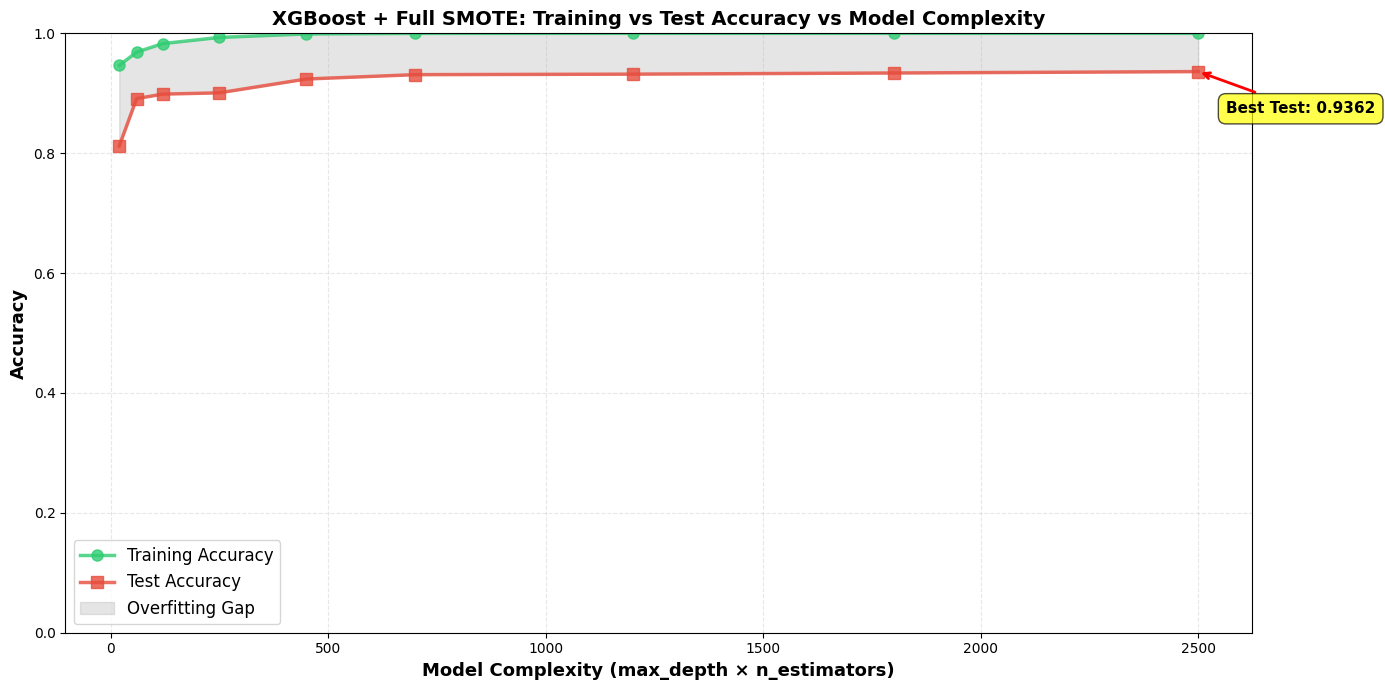

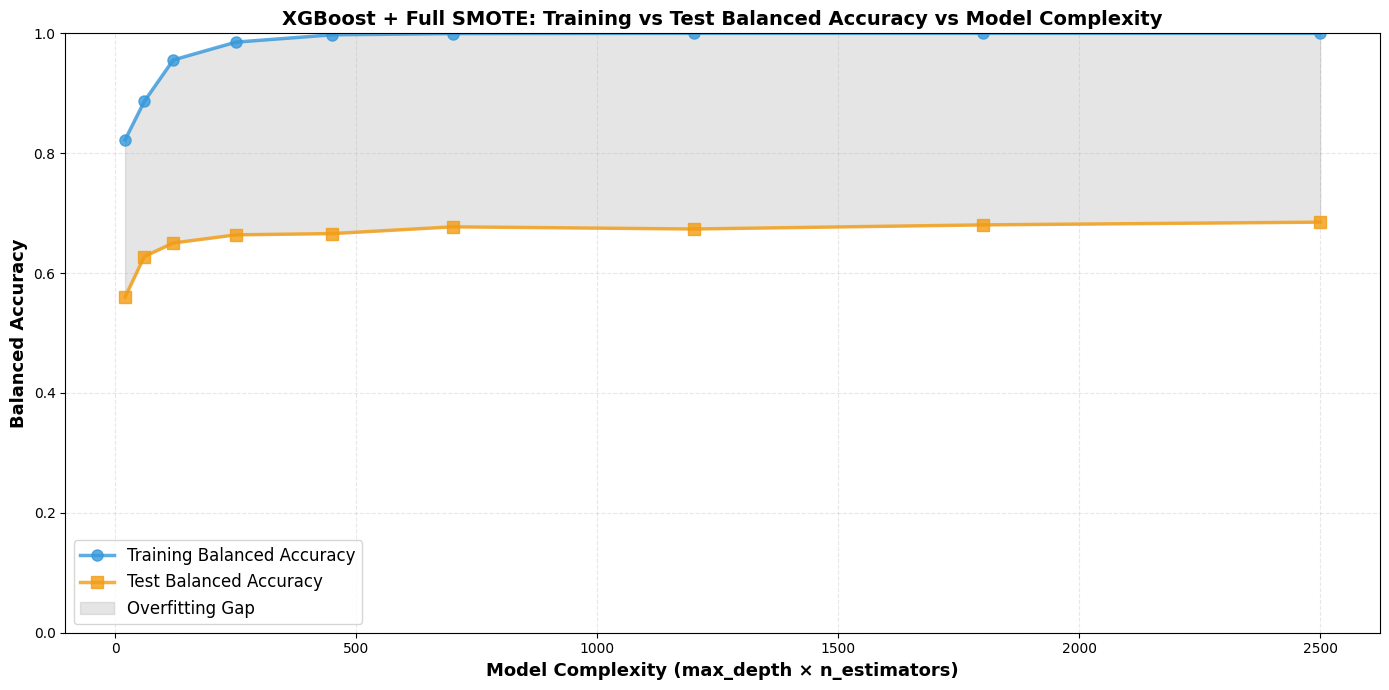

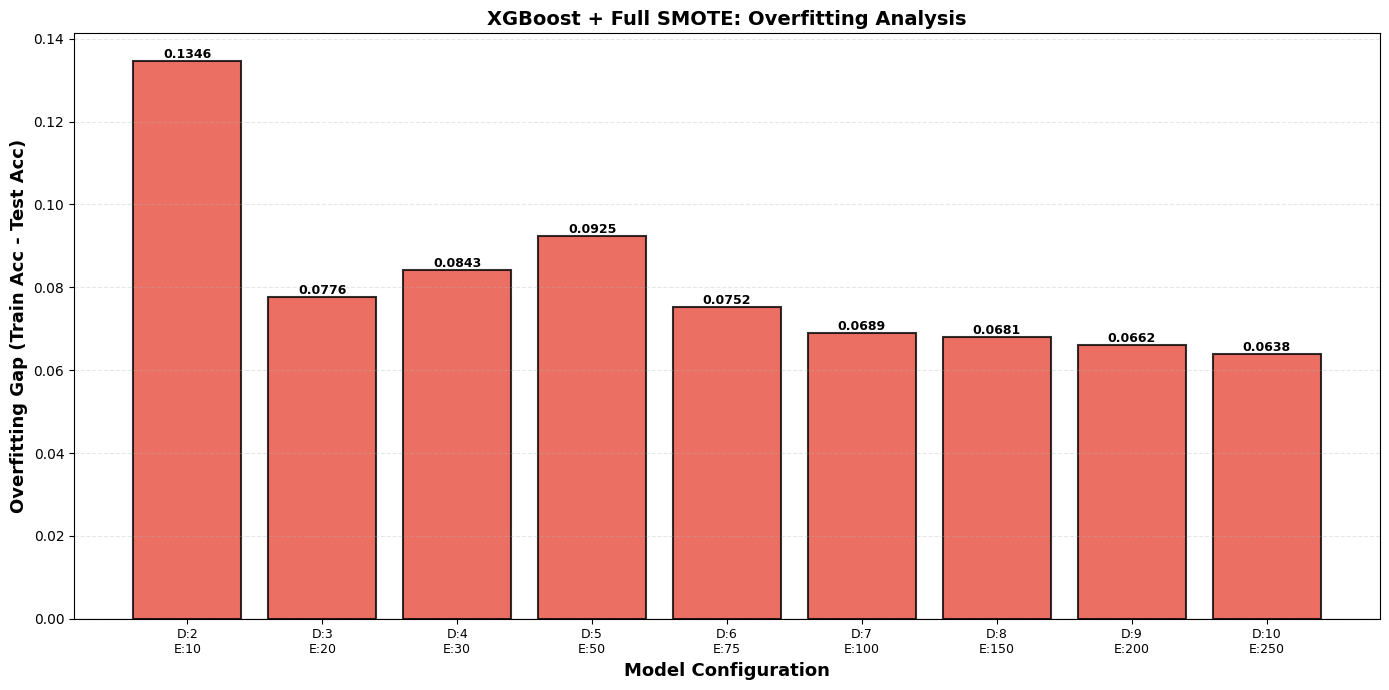

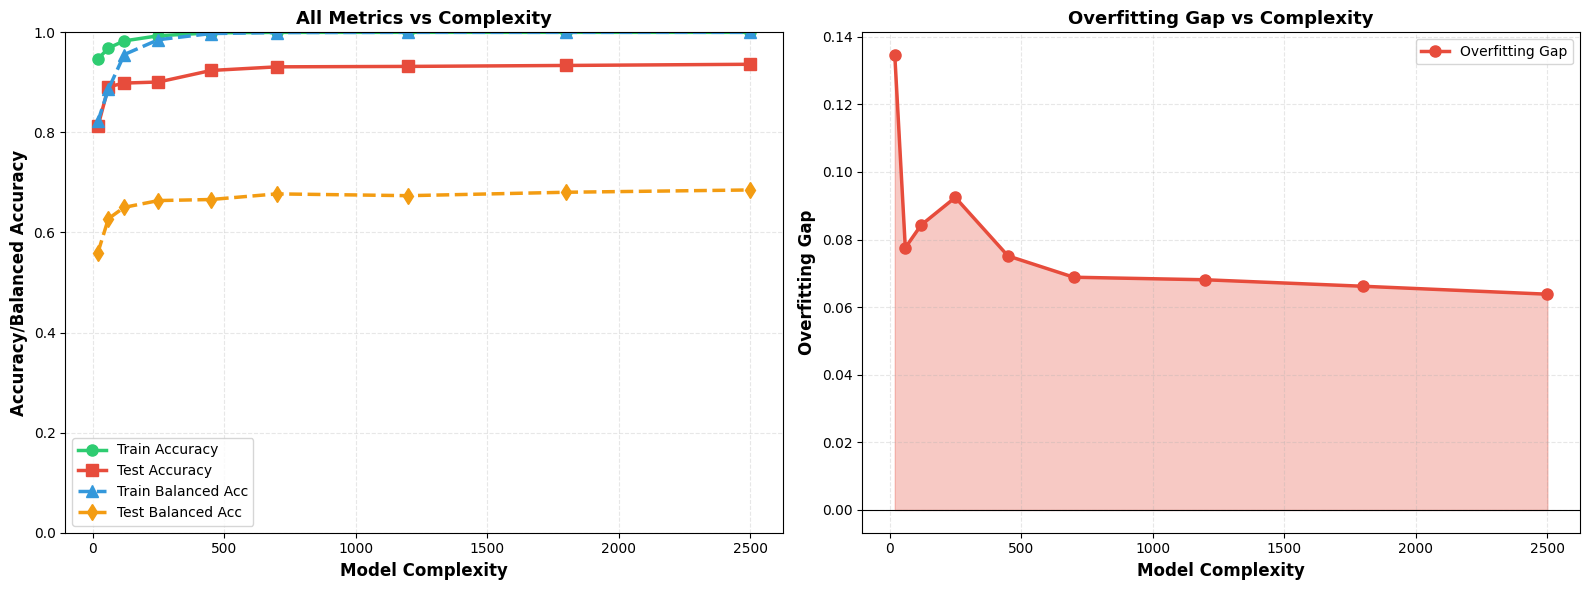


KEY INSIGHTS

✅ BEST TEST ACCURACY:
   Complexity: 2500 (Depth=10, Est=250)
   Test Accuracy: 0.9362
   Train Accuracy: 1.0000
   Overfitting Gap: 0.0638

✅ BEST GENERALIZATION (Least Overfitting):
   Complexity: 2500 (Depth=10, Est=250)
   Test Accuracy: 0.9362
   Train Accuracy: 1.0000
   Overfitting Gap: 0.0638

✅ BEST EFFICIENCY (Performance per Complexity):
   Complexity: 20 (Depth=2, Est=10)
   Test Accuracy: 0.8119
   Train Accuracy: 0.9465
   Efficiency: 4.0596



In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE

print("=" * 80)
print("TRAINING XGBoost + Full SMOTE MODELS WITH VARYING COMPLEXITY")
print("=" * 80)

complexity_configs = [
    {"max_depth": 2, "n_estimators": 10, "subsample": 0.8},
    {"max_depth": 3, "n_estimators": 20, "subsample": 0.8},
    {"max_depth": 4, "n_estimators": 30, "subsample": 0.8},
    {"max_depth": 5, "n_estimators": 50, "subsample": 0.8},
    {"max_depth": 6, "n_estimators": 75, "subsample": 0.8},
    {"max_depth": 7, "n_estimators": 100, "subsample": 0.8},
    {"max_depth": 8, "n_estimators": 150, "subsample": 0.8},
    {"max_depth": 9, "n_estimators": 200, "subsample": 0.8},
    {"max_depth": 10, "n_estimators": 250, "subsample": 0.8},
]

# Store results
complexity_analysis = {
    "complexity_score": [],
    "max_depth": [],
    "n_estimators": [],
    "train_accuracy": [],
    "test_accuracy": [],
    "train_balanced_accuracy": [],
    "test_balanced_accuracy": [],
}



print("\nTraining models with increasing complexity...")
print(f"{'Config':<10} {'Depth':<6} {'Est':<6} {'Complexity':<12} {'Train Acc':<12} {'Test Acc':<12} {'Overfit':<10}")
print("-" * 90)

for idx, config in enumerate(complexity_configs):
    max_d = config["max_depth"]
    n_est = config["n_estimators"]
    subsamp = config["subsample"]
    
    # Calculate complexity score
    complexity = max_d * n_est
    
    # Apply SMOTE to training data
    class_dist = pd.Series(y_train).value_counts()
    max_count = max(class_dist.values)
    sampling_strategy = {cls: max_count for cls in class_dist.keys()}
    
    sm = SMOTE(
        random_state=RANDOM_STATE,
        sampling_strategy=sampling_strategy,
        k_neighbors=3
    )
    X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)
    
    # Train model
    model = XGBClassifier(
        objective="multi:softmax",
        num_class=len(class_names),
        eval_metric="mlogloss",
        learning_rate=0.1,
        n_estimators=n_est,
        max_depth=max_d,
        subsample=subsamp,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_lambda=0.5,
        reg_alpha=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    )
    
    model.fit(X_train_smote, y_train_smote)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    overfit = train_acc - test_acc
    
    complexity_analysis["complexity_score"].append(complexity)
    complexity_analysis["max_depth"].append(max_d)
    complexity_analysis["n_estimators"].append(n_est)
    complexity_analysis["train_accuracy"].append(train_acc)
    complexity_analysis["test_accuracy"].append(test_acc)
    complexity_analysis["train_balanced_accuracy"].append(train_bal_acc)
    complexity_analysis["test_balanced_accuracy"].append(test_bal_acc)
    
    print(f"Model {idx+1:<2} {max_d:<6} {n_est:<6} {complexity:<12} {train_acc:<12.4f} {test_acc:<12.4f} {overfit:<10.4f}")

print("\n" + "=" * 80)
print("COMPLEXITY ANALYSIS COMPLETE")
print("=" * 80)

# Create DataFrame for easier analysis
df_complexity = pd.DataFrame(complexity_analysis)

print("\nComplexity Analysis Summary:")
print(df_complexity.to_string(index=False))


fig, ax = plt.subplots(figsize=(14, 7))

x = df_complexity["complexity_score"]
train_acc = df_complexity["train_accuracy"]
test_acc = df_complexity["test_accuracy"]

# Plot lines
ax.plot(x, train_acc, marker='o', linewidth=2.5, markersize=8, 
        label="Training Accuracy", color="#2ecc71", alpha=0.8)
ax.plot(x, test_acc, marker='s', linewidth=2.5, markersize=8, 
        label="Test Accuracy", color="#e74c3c", alpha=0.8)

# Fill between to show overfitting gap
ax.fill_between(x, train_acc, test_acc, alpha=0.2, color='gray', label="Overfitting Gap")

# Formatting
ax.set_xlabel("Model Complexity (max_depth × n_estimators)", fontsize=13, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=13, fontweight='bold')
ax.set_title("XGBoost + Full SMOTE: Training vs Test Accuracy vs Model Complexity", 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.0])

# Add annotations for best points
best_test_idx = test_acc.idxmax()
best_test_acc = test_acc[best_test_idx]
best_test_complexity = x[best_test_idx]

ax.annotate(f'Best Test: {best_test_acc:.4f}', 
            xy=(best_test_complexity, best_test_acc),
            xytext=(20, -30), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', lw=2),
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(14, 7))

train_bal_acc = df_complexity["train_balanced_accuracy"]
test_bal_acc = df_complexity["test_balanced_accuracy"]

ax.plot(x, train_bal_acc, marker='o', linewidth=2.5, markersize=8, 
        label="Training Balanced Accuracy", color="#3498db", alpha=0.8)
ax.plot(x, test_bal_acc, marker='s', linewidth=2.5, markersize=8, 
        label="Test Balanced Accuracy", color="#f39c12", alpha=0.8)

ax.fill_between(x, train_bal_acc, test_bal_acc, alpha=0.2, color='gray', label="Overfitting Gap")

ax.set_xlabel("Model Complexity (max_depth × n_estimators)", fontsize=13, fontweight='bold')
ax.set_ylabel("Balanced Accuracy", fontsize=13, fontweight='bold')
ax.set_title("XGBoost + Full SMOTE: Training vs Test Balanced Accuracy vs Model Complexity", 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(14, 7))

overfitting_gap = df_complexity["train_accuracy"] - df_complexity["test_accuracy"]

ax.bar(range(len(x)), overfitting_gap, color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

ax.set_xlabel("Model Configuration", fontsize=13, fontweight='bold')
ax.set_ylabel("Overfitting Gap (Train Acc - Test Acc)", fontsize=13, fontweight='bold')
ax.set_title("XGBoost + Full SMOTE: Overfitting Analysis", fontsize=14, fontweight='bold')
ax.set_xticks(range(len(x)))
ax.set_xticklabels([f"D:{d}\nE:{e}" for d, e in zip(df_complexity["max_depth"], df_complexity["n_estimators"])], 
                     fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, gap in enumerate(overfitting_gap):
    ax.text(i, gap, f'{gap:.4f}', ha='center', va='bottom' if gap > 0 else 'top', 
            fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# ============================================================================
# Visualization 4: Side-by-side Comparison
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: All metrics
ax = axes[0]
ax.plot(x, train_acc, marker='o', linewidth=2.5, markersize=8, label="Train Accuracy", color="#2ecc71")
ax.plot(x, test_acc, marker='s', linewidth=2.5, markersize=8, label="Test Accuracy", color="#e74c3c")
ax.plot(x, train_bal_acc, marker='^', linewidth=2.5, markersize=8, label="Train Balanced Acc", color="#3498db", linestyle='--')
ax.plot(x, test_bal_acc, marker='d', linewidth=2.5, markersize=8, label="Test Balanced Acc", color="#f39c12", linestyle='--')

ax.set_xlabel("Model Complexity", fontsize=12, fontweight='bold')
ax.set_ylabel("Accuracy/Balanced Accuracy", fontsize=12, fontweight='bold')
ax.set_title("All Metrics vs Complexity", fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 1.0])

# Right: Overfitting vs Complexity
ax = axes[1]
ax.plot(x, overfitting_gap, marker='o', linewidth=2.5, markersize=8, 
        color='#e74c3c', label="Overfitting Gap")
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.fill_between(x, 0, overfitting_gap, alpha=0.3, color='#e74c3c')

ax.set_xlabel("Model Complexity", fontsize=12, fontweight='bold')
ax.set_ylabel("Overfitting Gap", fontsize=12, fontweight='bold')
ax.set_title("Overfitting Gap vs Complexity", fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

best_test_idx = test_acc.idxmax()
best_test_model = df_complexity.iloc[best_test_idx]

print(f"\n✅ BEST TEST ACCURACY:")
print(f"   Complexity: {best_test_model['complexity_score']:.0f} (Depth={best_test_model['max_depth']:.0f}, Est={best_test_model['n_estimators']:.0f})")
print(f"   Test Accuracy: {best_test_model['test_accuracy']:.4f}")
print(f"   Train Accuracy: {best_test_model['train_accuracy']:.4f}")
print(f"   Overfitting Gap: {best_test_model['train_accuracy'] - best_test_model['test_accuracy']:.4f}")

best_generalization_idx = (df_complexity["train_accuracy"] - df_complexity["test_accuracy"]).idxmin()
best_gen_model = df_complexity.iloc[best_generalization_idx]

print(f"\n✅ BEST GENERALIZATION (Least Overfitting):")
print(f"   Complexity: {best_gen_model['complexity_score']:.0f} (Depth={best_gen_model['max_depth']:.0f}, Est={best_gen_model['n_estimators']:.0f})")
print(f"   Test Accuracy: {best_gen_model['test_accuracy']:.4f}")
print(f"   Train Accuracy: {best_gen_model['train_accuracy']:.4f}")
print(f"   Overfitting Gap: {best_gen_model['train_accuracy'] - best_gen_model['test_accuracy']:.4f}")


efficiency = df_complexity["test_accuracy"] / (df_complexity["complexity_score"] / 100)
best_efficiency_idx = efficiency.idxmax()
best_eff_model = df_complexity.iloc[best_efficiency_idx]

print(f"\n✅ BEST EFFICIENCY (Performance per Complexity):")
print(f"   Complexity: {best_eff_model['complexity_score']:.0f} (Depth={best_eff_model['max_depth']:.0f}, Est={best_eff_model['n_estimators']:.0f})")
print(f"   Test Accuracy: {best_eff_model['test_accuracy']:.4f}")
print(f"   Train Accuracy: {best_eff_model['train_accuracy']:.4f}")
print(f"   Efficiency: {efficiency[best_efficiency_idx]:.4f}")

print("\n" + "=" * 80)


# Conclusions & Comparative Summary

**Overview:** We evaluated four XGBoost-based approaches to address class imbalance and improve minority-class detection:
1. XGBoost with tuned hyperparameters (baseline tuned model).
2. XGBoost + Controlled SMOTE (targeted, moderate upsampling).
3. XGBoost + Full SMOTE (full class balancing).
4. XGBoost + SMOTE (X-only) + Class Weights (combined resampling & loss reweighting).

**Why this progression:**
- Start with a tuned XGBoost to establish a performant baseline without altering data distribution.
- Apply SMOTE variants to provide the model more minority-class examples and allow better decision-boundary learning.
- Use class weights when reweighting the loss is preferable to modifying sample counts or when synthetic samples risk introducing noise.

**Evaluation priorities:** PR AUC and Recall for the minority class are the primary metrics. Use ROC AUC, Precision, F1, and confusion matrices as supporting metrics. Report CV mean ± std for robustness.

**Comparative results (fill with your numbers):**
- XGBoost (Tuned): ROC AUC=__, PR AUC=__, Precision=__, Recall=__, F1=__.
- XGBoost + Controlled SMOTE: ROC AUC=__, PR AUC=__, Precision=__, Recall=__, F1=__.
- XGBoost + Full SMOTE: ROC AUC=__, PR AUC=__, Precision=__, Recall=__, F1=__.
- XGBoost + SMOTE (X) + Class Weights: ROC AUC=__, PR AUC=__, Precision=__, Recall=__, F1=__.

**Interpretation guidance:**
- If tuned XGBoost shows good ROC AUC but low PR AUC/Recall, the model is biased toward the majority class and needs resampling or reweighting.
- Controlled SMOTE often improves recall with limited precision degradation — a good middle ground.
- Full SMOTE may maximize recall but can increase false positives (lower precision) and risk overfitting.
- SMOTE + class weights can further improve minority detection but requires careful validation to avoid overfitting.

**Recommendation:** Choose the model that meets the project’s recall threshold while maximizing PR AUC and showing consistent CV performance. If recall is critical and false positives are acceptable, prefer the model with the highest recall (often Full SMOTE or SMOTE+weights). If balance is needed, prefer Controlled SMOTE or SMOTE+weights validated on a holdout set.

**Next steps:**
- Populate the comparison table in the notebook with the numeric results from the model-comparison cell.
- Produce ROC and Precision–Recall plots comparing all four models on the same axes.
- Run bootstrap or statistical tests for AUC/PR differences if you need significance estimates.
- Validate the selected model on an untouched holdout set and check calibration if probabilities are used for decisions.